In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib as plt
import seaborn
%run "Librerias.ipynb"

In [78]:
def Ventas_Diarias_JFV(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
    SELECT *  except(tienda)
    FROM `inretail-negocios-sd.intercorpretail.JFV_VENTAS_TIENDAS_MASS` 
    """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion

def Ventas_Formatos(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
    SELECT *
    FROM (
    SELECT *,ROW_NUMBER() OVER(PARTITION BY periodo,place_id,channel_analytic,itc_company_name_enablement order by venta_mes desc)Orden
    FROM `inretail-negocios-sd.intercorpretail_mass.Ventas_Diarias_IR_Producto2`
     WHERE  itc_company_name_enablement in ('Mass','Plaza Vea','Vivanda')
     and channel_analytic not like '%ONLINE%'
    )
    where orden<=10 
    order by place_id desc 
    """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 


def Ventas_Formatos_Mensuales(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
     SELECT place_id,itc_company_name_analytic,itc_company_name_enablement,periodo,sum(venta_mes)Venta_Acum_mes
    FROM `inretail-negocios-sd.intercorpretail_mass.Ventas_Diarias_IR_Producto2`
    group by place_id,place_id,itc_company_name_analytic,itc_company_name_enablement,periodo
    """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 


def Canasta_Mensual_Mass(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
     SELECT  periodo,
        place_id,
        place_description,
        channel,
        channel_analytic,
        itc_company_name_analytic,
        itc_company_name_enablement,
        "Canasta IC" product_item_description,
        "Canasta IC" product_group,
        "Canasta IC" product_family,
        "99999999999" product_item_id,
        "X" product_item_unit_measure,
        "Canasta IC" product_subcategory,
        "Canasta IC" product_subfamily,
        "Canasta IC" product_type,
        sum(unidades_mes)unidades_mes,sum(venta_mes)venta_mes,
        1 Orden,
        sum(precio_mes)precio_producto,
        0 Participacion
FROM 
(
SELECT *,
Case when itc_company_name_enablement='Mass' and product_item_id in ('00020107266','00000959308','00020162294') then 'Canasta'
     when itc_company_name_enablement='Plaza Vea' and product_item_id in ('00020162294','00020353008','00000959308') then 'Canasta'
          when itc_company_name_enablement='Vivanda' and product_item_id in ('00020162294','00020353008','00020107266','00000959308','00020220322') then 'Canasta'
     else null end Flag_Canasta, 
venta_mes/unidades_mes precio_mes,ROW_NUMBER() OVER(PARTITION BY periodo,place_id,channel_analytic,itc_company_name_enablement order by venta_mes desc)Orden
    FROM `inretail-negocios-sd.intercorpretail_mass.Ventas_Diarias_IR_Producto2`
     WHERE   unidades_mes>0  and itc_company_name_enablement in ('Mass','Plaza Vea','Vivanda')
     and product_item_id in ('00020107266','00000959308','00020162294','00020353008','00020220319','00000959308','00020220322')
     and channel_analytic not like '%ONLINE%'
)
WHERE FLAG_CANASTA='Canasta'
group by periodo,
        place_id, 
        place_description,
        channel,
        channel_analytic,
        itc_company_name_analytic,
        itc_company_name_enablement
    order by place_id desc ,periodo desc
    """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 

In [ ]:
Ruta_Inicial=os.getcwd()
Ruta_Inicial

In [4]:
os.chdir(Ruta_Inicial)
ruta=Ruta_Inicial.replace("\\","/")
Llave=[s for s in os.listdir(ruta) if any(xs in s for xs in ['.json'])][0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
client = bigquery.Client()

In [79]:
Ventas_Diaras_Plot=Ventas_Diarias_JFV(Llave)
Ventas_Diaras_Plot

,codigo_local,fecha,Venta,fechamin,DifDias
0,M244,2015-10-04,2877.22,2015-07-24,73
1,M244,2019-10-02,4952.29,2015-07-24,1527
2,M244,2020-04-13,10231.95,2015-07-24,1716
3,M244,2022-05-28,4866.56,2015-07-24,2469
4,M244,2017-10-26,3912.27,2015-07-24,823
...,...,...,...,...,...
1251986,1774,2024-04-19,3629.95,2023-12-20,121
1251987,1774,2024-07-14,5055.94,2023-12-20,207
1251988,1774,2024-06-02,5624.69,2023-12-20,165
1251989,1774,2024-02-28,2427.30,2023-12-20,70


Q1 (25th percentile): 3004.93
Q2 (50th percentile): 4167.22
Q3 (75th percentile): 5678.81


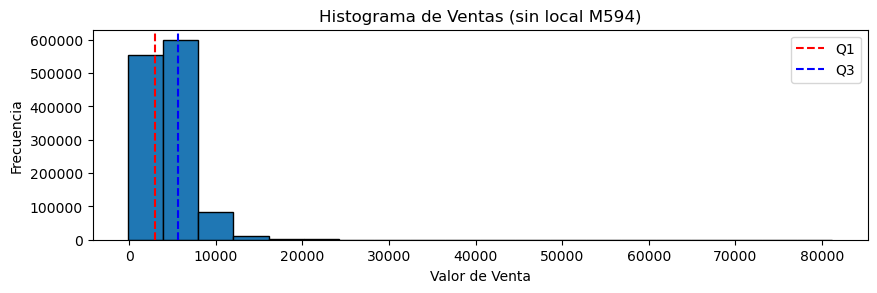

In [85]:
import matplotlib.pyplot as plt
import numpy as np


# Calcular cuartiles
q1 = np.percentile(Ventas_Diaras_Plot['Venta'], 25)
q2 = np.percentile(Ventas_Diaras_Plot['Venta'], 50)
q3 = np.percentile(Ventas_Diaras_Plot['Venta'], 75)

print("Q1 (25th percentile):", q1)
print("Q2 (50th percentile):", q2)
print("Q3 (75th percentile):", q3)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.hist(Ventas_Diaras_Plot['Venta'], bins=20, edgecolor='black')
plt.axvline(x=q1, color='r', linestyle='--', label='Q1')
plt.axvline(x=q3, color='b', linestyle='--', label='Q3')
plt.xlabel('Valor de Venta')
plt.ylabel('Frecuencia')
plt.title('Histograma de Ventas (sin local M594)')
plt.legend()

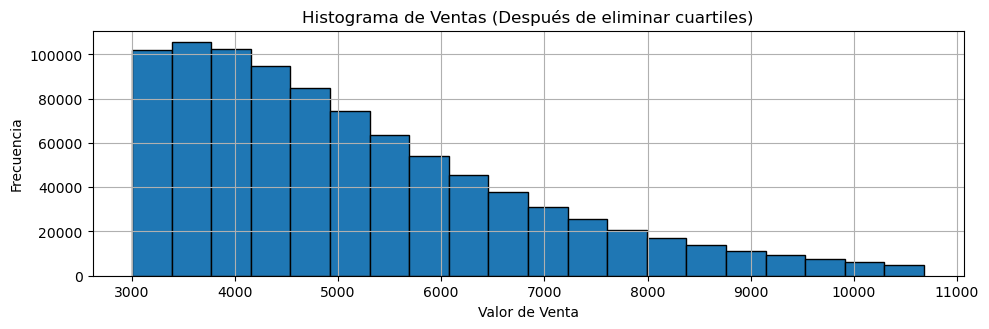

In [88]:
data_filtered = aux[(aux['Venta'] >= q1) & (aux['Venta'] <= q3+5000)]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 2)
plt.hist(data_filtered['Venta'], bins=20, edgecolor='black')
plt.xlabel('Valor de Venta')
plt.ylabel('Frecuencia')
plt.title('Histograma de Ventas (Después de eliminar cuartiles)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
Tabla_Base=Ventas_Formatos(Llave)
print(Tabla_Base.shape)
Venta_Mensual=Ventas_Formatos_Mensuales(Llave)
Venta_Mensual.shape

(492432, 18)


(222230, 5)

In [6]:
Canasta_Mass=Canasta_Mensual_Mass(Llave)
Canasta_Mass

,periodo,place_id,place_description,channel,channel_analytic,itc_company_name_analytic,itc_company_name_enablement,product_item_description,product_group,product_family,product_item_id,product_item_unit_measure,product_subcategory,product_subfamily,product_type,unidades_mes,venta_mes,Orden,precio_producto,Participacion
0,2024-05-01,X210,SANTA CRUZ - PVE,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Plaza Vea,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,137.000,1947.61,1,22.481375,0
1,2024-04-01,X210,SANTA CRUZ - PVE,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Plaza Vea,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,432.000,5659.39,1,21.854418,0
2,2024-03-01,X210,SANTA CRUZ - PVE,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Plaza Vea,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,382.000,4621.69,1,22.455514,0
3,2024-02-01,X210,SANTA CRUZ - PVE,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Plaza Vea,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,308.000,3736.28,1,22.750531,0
4,2024-01-01,X210,SANTA CRUZ - PVE,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Plaza Vea,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,328.000,4554.37,1,23.009432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47754,2021-08-01,1000,VILLAT5 LO MS,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,1483.420,7703.92,1,16.058779,0
47755,2021-07-01,1000,VILLAT5 LO MS,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,2427.010,12372.52,1,15.343027,0
47756,2021-06-01,1000,VILLAT5 LO MS,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,1719.230,8556.59,1,14.862245,0
47757,2021-05-01,1000,VILLAT5 LO MS,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Canasta IC,Canasta IC,Canasta IC,99999999999,X,Canasta IC,Canasta IC,Canasta IC,1481.792,7037.48,1,14.148650,0


In [7]:
Tabla_Mensualizada=pd.merge(Tabla_Base,Venta_Mensual,on=['place_id','periodo','itc_company_name_analytic','itc_company_name_enablement'],how='left')
Tabla_Mensualizada=Tabla_Mensualizada[(Tabla_Mensualizada['itc_company_name_enablement']=='Mass') & (Tabla_Mensualizada['Venta_Acum_mes']>20000)]
Tabla_Mensualizada['precio_producto']=Tabla_Mensualizada['venta_mes']/Tabla_Mensualizada['unidades_mes']
Tabla_Mensualizada['Participacion']=Tabla_Mensualizada['venta_mes']/Tabla_Mensualizada['Venta_Acum_mes']
#Tabla_Base[(Tabla_Base['Orden']==1) & (Tabla_Base['itc_company_name_enablement']=='Mass')].head(5)

In [8]:
Canasta_Mass=pd.merge(Canasta_Mass,Venta_Mensual,on=['place_id','periodo','itc_company_name_analytic','itc_company_name_enablement'],how='left')

In [9]:
print(Tabla_Mensualizada.shape)
print(Canasta_Mass.shape)

(384933, 21)
(47759, 21)


In [10]:
Tabla_Mensualizada=pd.concat([Tabla_Mensualizada,Canasta_Mass])

In [11]:
Productos=Tabla_Mensualizada[['product_item_id','product_item_description','product_subcategory']].drop_duplicates(subset='product_item_id', keep='first')
Productos

,product_item_id,product_item_description,product_subcategory
101574,00020107266,Mass Huevo Granel Kg,Huevos
101575,00020008541,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
101576,00020162294,Imp Pollo Pierna C-E Cg Kg,Pollo
101577,00000979253,Pilsen Cerveza Pk 12 Lt 355 Ml,Cerveza
101578,00020162287,Imp Pollo Filete De Pechuga Cg Kg,Pollo
...,...,...,...
484345,00020329476,Fatica Hielo 3kg,Hielo
484864,00000142433,Colchon Easy De 1 5 Plz,Colchones
485054,00000965773,Arica Durazno En Almibar Un820g,Conservas
486914,00020219278,Bell-S Pan De Molde Integral Bl 500g,Panaderia Industrial


In [12]:
#Top_productos=Tabla_Mensualizada[(Tabla_Mensualizada['Orden']==1) & (Tabla_Mensualizada['itc_company_name_enablement']=='Mass')].groupby(['product_item_id','periodo','place_id','place_description'])[['venta_mes','Participacion']].mean().reset_index().sort_values(['product_item_id','periodo'])
Top_productos=Tabla_Mensualizada[['product_item_id','periodo','place_id','itc_company_name_enablement','place_description','precio_producto','unidades_mes','venta_mes','Participacion','Venta_Acum_mes','Orden']]
print(Top_productos.shape)
Top_productos=pd.merge(Top_productos,Productos,on='product_item_id',how='left')
Top_productos

(432692, 11)


,product_item_id,periodo,place_id,itc_company_name_enablement,place_description,precio_producto,unidades_mes,venta_mes,Participacion,Venta_Acum_mes,Orden,product_item_description,product_subcategory
0,00020107266,2023-04-01,M890,Mass,MASS PEDRO 2 BR MS,8.270808,1394.715,11535.42,0.08604,134070.28,1,Mass Huevo Granel Kg,Huevos
1,00020008541,2023-04-01,M890,Mass,MASS PEDRO 2 BR MS,4.659272,1263.000,5884.66,0.043892,134070.28,2,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
2,00020162294,2023-04-01,M890,Mass,MASS PEDRO 2 BR MS,5.702820,777.575,4434.37,0.033075,134070.28,3,Imp Pollo Pierna C-E Cg Kg,Pollo
3,00000979253,2023-04-01,M890,Mass,MASS PEDRO 2 BR MS,33.424194,93.000,3108.45,0.023185,134070.28,4,Pilsen Cerveza Pk 12 Lt 355 Ml,Cerveza
4,00020162287,2023-04-01,M890,Mass,MASS PEDRO 2 BR MS,13.237000,230.000,3044.51,0.022708,134070.28,5,Imp Pollo Filete De Pechuga Cg Kg,Pollo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432687,99999999999,2021-08-01,1000,Mass,VILLAT5 LO MS,16.058779,1483.420,7703.92,0.0,68548.59,1,Canasta IC,Canasta IC
432688,99999999999,2021-07-01,1000,Mass,VILLAT5 LO MS,15.343027,2427.010,12372.52,0.0,86230.95,1,Canasta IC,Canasta IC
432689,99999999999,2021-06-01,1000,Mass,VILLAT5 LO MS,14.862245,1719.230,8556.59,0.0,70509.69,1,Canasta IC,Canasta IC
432690,99999999999,2021-05-01,1000,Mass,VILLAT5 LO MS,14.148650,1481.792,7037.48,0.0,61578.10,1,Canasta IC,Canasta IC


In [13]:
Top_productos[Top_productos['place_id']=='M362'].groupby(['product_item_id'])[['Participacion']].count().reset_index().sort_values('Participacion',ascending=False)

,product_item_id,Participacion
65,99999999999,77
27,00020107266,74
12,00000959308,73
17,00020008541,58
5,00000107285,50
...,...,...
47,00020193770,1
46,00020189397,1
43,00020172823,1
1,00000021186,1


In [14]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
import pandas as pd

# Convertir la columna 'periodo' a tipo de datos de fecha si no lo está ya
Top_productos['periodo'] = pd.to_datetime(Top_productos['periodo'])

# Función para filtrar los datos según el producto, el lugar y el ITC company, y luego graficar la tendencia mes a mes
def graficar_tendencia(producto, lugar_id, itc_company):
    datos_seleccionados = Top_productos[(Top_productos['product_item_description'] == producto) & 
                                        (Top_productos['place_id'] == lugar_id) &
                                        (Top_productos['itc_company_name_enablement'] == itc_company)]
    datos_seleccionados = datos_seleccionados.set_index('periodo')  # Establecer 'periodo' como el índice para facilitar el filtrado por meses
    datos_seleccionados_mes = datos_seleccionados.resample('M').mean()  # Agregar los datos mensuales para suavizar la tendencia
    plt.figure(figsize=(10, 6))
    plt.plot(datos_seleccionados_mes.index, datos_seleccionados_mes['precio_producto'], marker='o', label='Precio producto')
    plt.xlabel('Periodo')
    plt.ylabel('Precio')
    plt.title('Tendencia del Precio Mes a Mes para el Producto {} en {} (ITC Company: {})'.format(producto, lugar_id, itc_company))
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Obtener las opciones disponibles para el producto, el lugar y el ITC company
productos_disponibles = list(Top_productos['product_item_description'].unique())
lugares_disponibles = list(Top_productos['place_id'].unique())
itc_company_disponibles = list(Top_productos['itc_company_name_enablement'].unique())

# Crear los widgets desplegables para el producto, el lugar y el ITC company
widget_producto = widgets.Dropdown(options=productos_disponibles, description='Producto:')
widget_lugar_id = widgets.Dropdown(options=lugares_disponibles, description='Lugar ID:')
widget_itc_company = widgets.Dropdown(options=itc_company_disponibles, description='ITC Company:')

# Conectar los widgets con la función de graficar
interact(graficar_tendencia, producto=widget_producto, lugar_id=widget_lugar_id, itc_company=widget_itc_company);

interactive(children=(Dropdown(description='Producto:', options=('Mass Huevo Granel Kg', 'Pilsen Callao Cervez…

In [15]:
# # Iterar sobre todas las tiendas
# for tienda_id in Top_productos['place_id'].unique():
#     print("Tienda:", tienda_id)
    
#     # 1. Identificar cuántos periodos diferentes hay en la tienda específica
#     periodos_diferentes = Top_productos[Top_productos['place_id'] == tienda_id]['periodo'].nunique()
#     if periodos_diferentes>=12:
        
#         # 2. Encontrar el máximo número de periodos en la tienda específica
#         max_periodos_tienda = Top_productos[Top_productos['place_id'] == tienda_id]['periodo'].nunique()

#         # 3. Encontrar los productos únicos que tienen al menos dos periodos menos que el máximo número de periodos en la tienda específica
#         min_periodos_validos = max_periodos_tienda - 4
#         validador = Top_productos[(Top_productos['place_id']==tienda_id)].groupby(['product_item_id','product_item_description'])['periodo'].agg(['nunique']).reset_index().sort_values('nunique',ascending=False)
#         productos_validos = list(validador[validador['nunique']>=min_periodos_validos].product_item_id)

#         # 4. Calcular la correlación para estos productos
#         correlaciones = {}
#         for producto_id in productos_validos:
#             datos_producto = Top_productos[(Top_productos['place_id'] == tienda_id) & (Top_productos['product_item_id'] == producto_id)]
#             correlacion = datos_producto[['product_item_id', 'product_item_description', 'precio_producto', 'Venta_Acum_mes']].corr().iloc[0, 1]
#             correlaciones[producto_id] = correlacion

#         # Imprimir las correlaciones para esta tienda
#         print("Correlaciones para productos con al menos {} periodos en la tienda {}: ".format(min_periodos_validos, tienda_id))
#         for producto_id, correlacion in correlaciones.items():
#             descripcion = validador[validador['product_item_id'] == producto_id]['product_item_description'].iloc[0]
#             print("Producto ID:", producto_id, ", Descripción:", descripcion, ", Correlación:", correlacion)
#     else:
#         next

In [16]:
Productos[Productos['product_item_id'].isin(['00020107266','00000959308','00020162294','00020235918','00020105658','00000199315','00020091631'])==True]

,product_item_id,product_item_description,product_subcategory
101574,00020107266,Mass Huevo Granel Kg,Huevos
101576,00020162294,Imp Pollo Pierna C-E Cg Kg,Pollo
101579,00020235918,Azucar Rubia San Jacinto X Kg,Azucar
101584,00000959308,Bell-S Aceite Vegetal Bt900ml,Aceites
101742,00000199315,Gloria Leche Evap Entera Lt400gr 6pk,Leche Envasada
102200,00020105658,Bunge Arroz Blanco Saco Kg 1000g,Arroz
106188,00020091631,Paracas Papel Higienico Naranja Pq24und,Papeleria Limpieza


In [17]:
# Crear un diccionario para almacenar la información de la mejor correlación por tienda
mejor_correlacion_por_tienda = {'Tienda': [], 'Producto ID': [], 'Descripción': [], 'Correlación': [], 'ITC Company': [], 'Subcategoría': []}

# Iterar sobre todas las tiendas
for tienda_id in Top_productos['place_id'].unique():
    periodos_diferentes = Top_productos[Top_productos['place_id'] == tienda_id]['periodo'].nunique()
    print(tienda_id)
    if periodos_diferentes >= 12:
        max_correlacion = float('-inf')
        mejor_producto_id = None
        mejor_descripcion = None
        mejor_itc_company = None
        mejor_subcategoria = None

        max_periodos_tienda = Top_productos[Top_productos['place_id'] == tienda_id]['periodo'].nunique()
        min_periodos_validos = max_periodos_tienda - 4
        validador = Top_productos[(Top_productos['place_id']==tienda_id)].groupby(['product_item_id','product_item_description'])['periodo'].agg(['nunique']).reset_index().sort_values('nunique',ascending=False)
        productos_validos = list(validador[validador['nunique']>=min_periodos_validos].product_item_id)
        
        # Calcular la correlación máxima para la tienda actual
        for producto_id in productos_validos:
            datos_producto = Top_productos[(Top_productos['place_id'] == tienda_id) & (Top_productos['product_item_id'] == producto_id)]
            correlacion = datos_producto[['precio_producto', 'Venta_Acum_mes']].corr().iloc[0, 1]
            if correlacion > max_correlacion:
                max_correlacion = correlacion
                mejor_producto_id = producto_id
                mejor_descripcion = validador[validador['product_item_id'] == producto_id]['product_item_description'].iloc[0]
                mejor_itc_company = datos_producto['itc_company_name_enablement'].iloc[0]
                mejor_subcategoria = datos_producto['product_subcategory'].iloc[0]

        # Guardar la información de la mejor correlación para esta tienda
        mejor_correlacion_por_tienda['Tienda'].append(tienda_id)
        mejor_correlacion_por_tienda['Producto ID'].append(mejor_producto_id)
        mejor_correlacion_por_tienda['Descripción'].append(mejor_descripcion)
        mejor_correlacion_por_tienda['Correlación'].append(max_correlacion)
        mejor_correlacion_por_tienda['ITC Company'].append(mejor_itc_company)
        mejor_correlacion_por_tienda['Subcategoría'].append(mejor_subcategoria)

# Convertir el diccionario a un DataFrame
df_mejor_correlacion = pd.DataFrame(mejor_correlacion_por_tienda)

# Imprimir los resultados
print("Productos con la mejor correlación por tienda:")
print(df_mejor_correlacion)

M890
M889
M888
M886
M885
M882
M881
M880
M879
M878
M877
M876
M875
M873
M872
M870
M869
M868
M867
M864
M863
M862
M861
M860
M858
M857
M856
M855
M854
M852
M851
M850
M849
M848
M847
M846
M844
M843
M841
M840
M839
M838
M837
M836
M835
M834
M833
M832
M831
M830
M829
M827
M826
M825
M824
M821
M819
M817
M816
M814
M813
M812
M811
M810
M808
M806
M805
M804
M802
M801
M800
M799
M798
M797
M796
M795
M794
M793
M792
M790
M789
M788
M786
M785
M784
M783
M780
M779
M777
M776
M775
M773
M772
M770
M768
M767
M765
M763
M762
M761
M760
M758
M756
M755
M754
M753
M752
M751
M750
M749
M748
M747
M746
M745
M744
M743
M742
M741
M740
M739
M737
M735
M734
M733
M731
M730
M729
M728
M727
M726
M725
M722
M721
M720
M718
M717
M716
M715
M714
M713
M712
M711
M709
M708
M707
M706
M705
M703
M702
M700
M699
M698
M697
M696
M695
M694
M693
M692
M691
M690
M689
M688
M686
M685
M684
M683
M682
M680
M679
M678
M677
M676
M675
M674
M673
M672
M671
M670
M669
M668
M667
M666
M665
M664
M663
M662
M661
M660
M658
M657
M653
M652
M650
M649
M648
M647
M646
M645
M644
M643


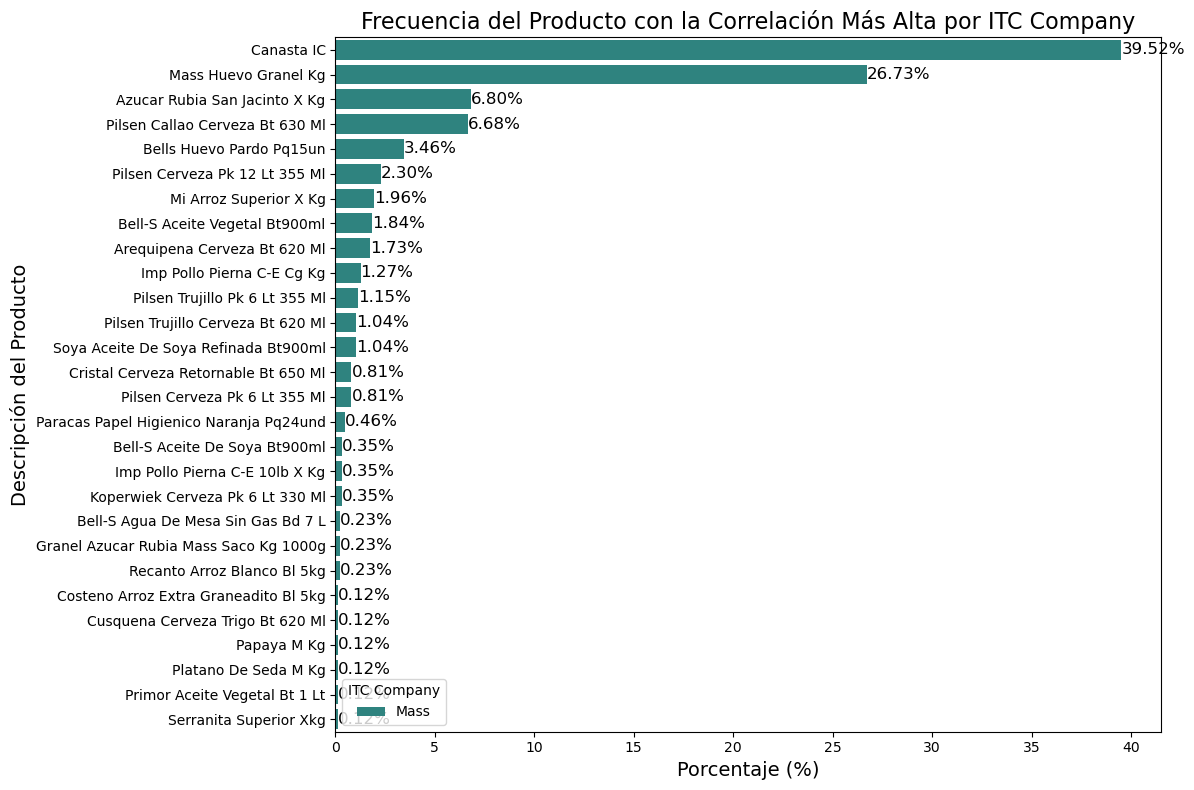

In [18]:
# Calcular la frecuencia del producto con la correlación más alta por itc_company_name_enablement
import seaborn as sns
df_contador_productos_itc = df_mejor_correlacion.groupby(['ITC Company', 'Descripción'])['Tienda'].count().reset_index()
df_contador_productos_itc=df_contador_productos_itc[df_contador_productos_itc['ITC Company']=='Mass']
df_contador_productos_itc = df_contador_productos_itc.rename(columns={'Tienda': 'Frecuencia'})

# Ordenar el DataFrame por itc_company_name_enablement y frecuencia descendente
df_contador_productos_itc = df_contador_productos_itc.sort_values(by=['ITC Company', 'Frecuencia'], ascending=[True, False])

# Calcular el total de frecuencias para obtener el porcentaje
total_frecuencias = df_contador_productos_itc['Frecuencia'].sum()

# Calcular el porcentaje para cada barra
df_contador_productos_itc['Porcentaje'] = (df_contador_productos_itc['Frecuencia'] / total_frecuencias) * 100

# Graficar la frecuencia del producto con la correlación más alta por itc_company_name_enablement
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=df_contador_productos_itc, y='Descripción', x='Porcentaje', hue='ITC Company', dodge=False, palette='viridis')

plt.xlabel('Porcentaje (%)', fontsize=14)  # Etiqueta del eje x con tamaño de fuente 14
plt.ylabel('Descripción del Producto', fontsize=14)  # Etiqueta del eje y con tamaño de fuente 14
plt.title('Frecuencia del Producto con la Correlación Más Alta por ITC Company', fontsize=16)  # Título del gráfico con tamaño de fuente 16

# Agregar etiquetas de porcentaje a las barras
for index, value in enumerate(df_contador_productos_itc['Porcentaje']):
    barplot.text(value, index, f'{value:.2f}%', ha='left', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

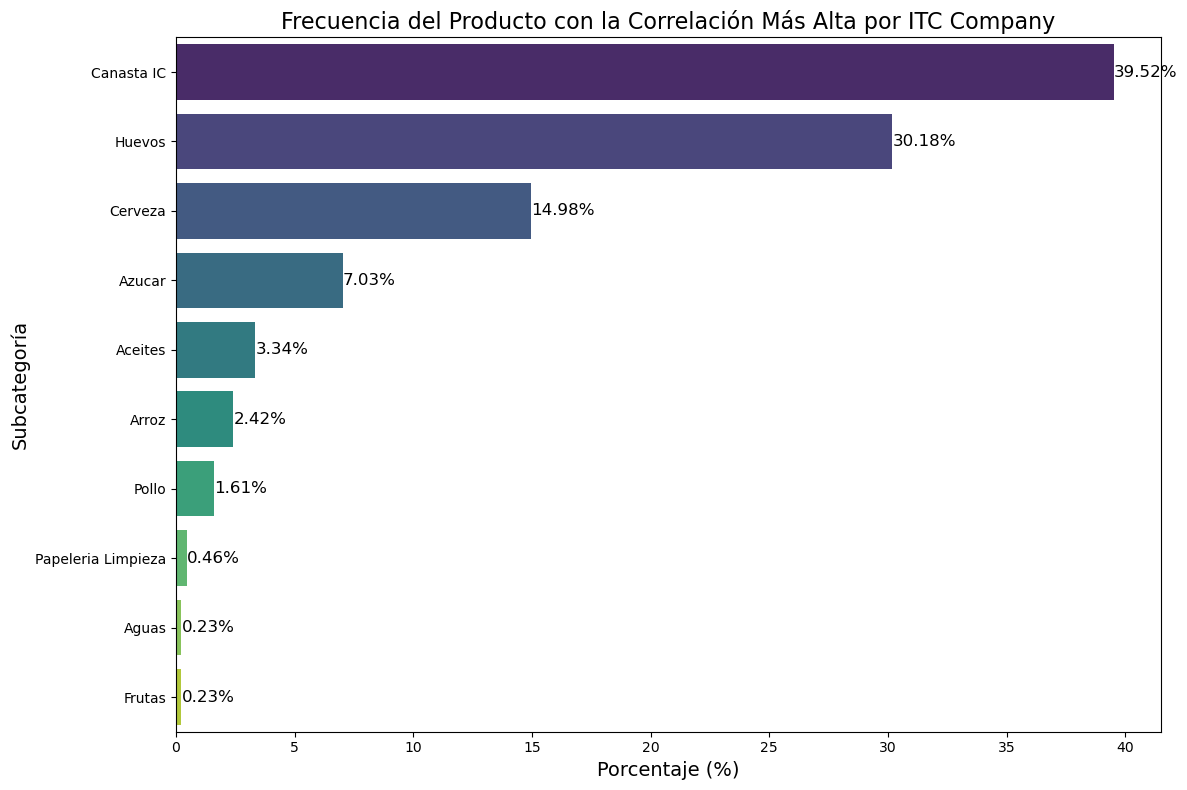

In [19]:
aux_graf=df_mejor_correlacion[df_mejor_correlacion['ITC Company']=='Mass']
aux_graf=aux_graf.groupby(['Subcategoría'])[['Tienda']].count().reset_index()

aux_graf = aux_graf.sort_values(by='Tienda', ascending=False)
total_frecuencias = aux_graf['Tienda'].sum()

# Calcular el porcentaje para cada barra
aux_graf['Porcentaje'] = (aux_graf['Tienda'] / total_frecuencias) * 100

# Graficar la frecuencia del producto con la correlación más alta por itc_company_name_enablement
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=aux_graf, y='Subcategoría', x='Porcentaje', dodge=False, palette='viridis')

plt.xlabel('Porcentaje (%)', fontsize=14)  # Etiqueta del eje x con tamaño de fuente 14
plt.ylabel('Subcategoría', fontsize=14)  # Etiqueta del eje y con tamaño de fuente 14
plt.title('Frecuencia del Producto con la Correlación Más Alta por ITC Company', fontsize=16)  # Título del gráfico con tamaño de fuente 16

# Agregar etiquetas de porcentaje a las barras
for index, value in enumerate(aux_graf['Porcentaje']):
    barplot.text(value, index, f'{value:.2f}%', ha='left', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [20]:
df_mejor_correlacion[(df_mejor_correlacion['ITC Company']=='Mass') & (df_mejor_correlacion['Subcategoría']=='Huevos')].groupby(['Producto ID','Descripción']).count()

,,Tienda,Correlación,ITC Company,Subcategoría
Producto ID,Descripción,,,,
00000002294,Bells Huevo Pardo Pq15un,30,30,30,30
00020107266,Mass Huevo Granel Kg,232,232,232,232


In [21]:
df_mejor_correlacion[(df_mejor_correlacion['ITC Company']=='Mass') & (df_mejor_correlacion['Subcategoría']=='Cerveza')].groupby(['Producto ID','Descripción']).count().sort_values('Tienda',ascending=False)

,,Tienda,Correlación,ITC Company,Subcategoría
Producto ID,Descripción,,,,
00020008541,Pilsen Callao Cerveza Bt 630 Ml,58,58,58,58
00000979253,Pilsen Cerveza Pk 12 Lt 355 Ml,20,20,20,20
00000965652,Arequipena Cerveza Bt 620 Ml,15,15,15,15
00020057084,Pilsen Trujillo Pk 6 Lt 355 Ml,10,10,10,10
00000975312,Pilsen Trujillo Cerveza Bt 620 Ml,9,9,9,9
00000988971,Cristal Cerveza Retornable Bt 650 Ml,7,7,7,7
00020055168,Pilsen Cerveza Pk 6 Lt 355 Ml,7,7,7,7
00020107467,Koperwiek Cerveza Pk 6 Lt 330 Ml,3,3,3,3
00000938825,Cusquena Cerveza Trigo Bt 620 Ml,1,1,1,1


In [22]:
Top_productos[Top_productos['product_item_id']=='00000975312'].place_description.unique()

array(['CELSO8 TRU MS', 'JOSEI1 TRU MS', 'ROMAC5 TRU MS',
       'EGIPTO6 TRU MS', 'GRAU54 TRU MS', 'MILAGRO5 TRU MS',
       'MARIA6 TRU MS', 'LARCO11 TRU MS', 'PEDRO8 TRU MS',
       'PANAME9 TRU MS', 'GRAU9 TRU MS', 'SAUCES8 TRU MS',
       'VICTOR18 TRU MS', 'PROGRE3 TRU MS', 'HAYAR3 TRU MS',
       'MATEO2 TRU MS', 'GARCIA16 TRU MS', 'VICTOR10 TRU MS',
       'VIRU20 TRU MS', 'RAMONG1 TRU MS', 'EJERCI3 TRU MS',
       '5NOV7 TRU MS', 'PANAME4 TRU MS', 'ALAMEDA 2 TRU MS',
       'JUNIN A7 TRU MS', 'VALLEJO 4 TRU MS', 'PRADA O13 TRU MS',
       'MERCED 3 TRU MS', 'INDOAME 5 TRU MS', 'SANTA 13 TRU MS',
       'BOLOGNE 4 TRU MS', 'TUPAC 6 TRU MS', 'METROPOL 1 TRU MS',
       'PANAME A1 TRU MS', 'WICHAN 30 TRU MS', 'VALLE C57 TRU MS',
       'OCTUBRE 7 TRU MS', 'LARCO 6 TRU MS', 'GRAU 1 TRU MS',
       'CONDOR 13 TRU MS', 'CAHUID Q42 TRU MS', 'ANGELES 3 TRU MS',
       'ZAFIROS 2 TRU MS', 'INCAS 4�\xa0TRU MS', 'JUAN 5 TRU MS',
       'MIGUEL 2 TRU MS', 'VALLEE3 TRU MS', 'ESMERAL 3 TRU 

In [23]:
Top_productos[(Top_productos['Participacion']>0.1)][['product_item_description','product_subcategory']].drop_duplicates()

,product_item_description,product_subcategory
40,Mass Huevo Granel Kg,Huevos
920,Pilsen Cerveza Pk 12 Lt 355 Ml,Cerveza
1140,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
1660,Bell-S Aceite De Soya Bt900ml,Aceites
1731,Soya Aceite De Soya Refinada Bt900ml,Aceites
1881,Bunge Arroz Granel Saco Kg 1000 Gr,Arroz
2650,Bell-S Aceite Vegetal Bt900ml,Aceites
6640,Bunge Arroz Granel Kg,Arroz
11130,Arequipena Cerveza Bt 620 Ml,Cerveza
14940,Ideal Cremosita Mezcla Lact Lt395gr 6pk,Leche Envasada


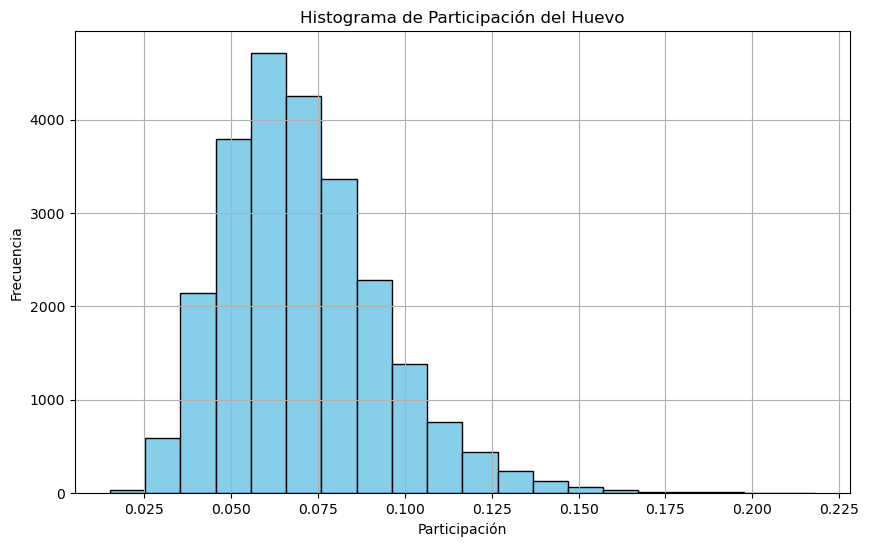

In [24]:
aux2=Top_productos[(Top_productos['Orden']==1) & (Top_productos['product_item_id']=='00020107266')]
import matplotlib.pyplot as plt

# Filtrar los datos
aux2 = Top_productos[(Top_productos['Orden'] == 1) & (Top_productos['product_item_id'] == '00020107266')]

# Plotear el histograma de la participación
plt.figure(figsize=(10, 6))
plt.hist(aux2['Participacion'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Participación')
plt.ylabel('Frecuencia')
plt.title('Histograma de Participación del Huevo')
plt.grid(True)
plt.show()

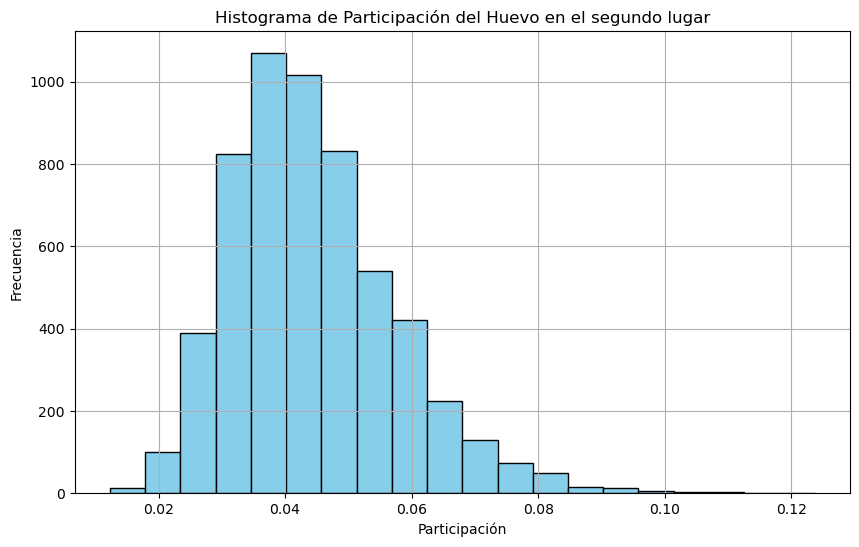

In [77]:
import matplotlib.pyplot as plt

# Filtrar los datos
aux2 = Top_productos[(Top_productos['Orden'] == 2) & (Top_productos['product_item_id'] == '00020107266')]

# Plotear el histograma de la participación
plt.figure(figsize=(10, 6))
plt.hist(aux2['Participacion'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Participación')
plt.ylabel('Frecuencia')
plt.title('Histograma de Participación del Huevo en el segundo lugar')
plt.grid(True)
plt.show()

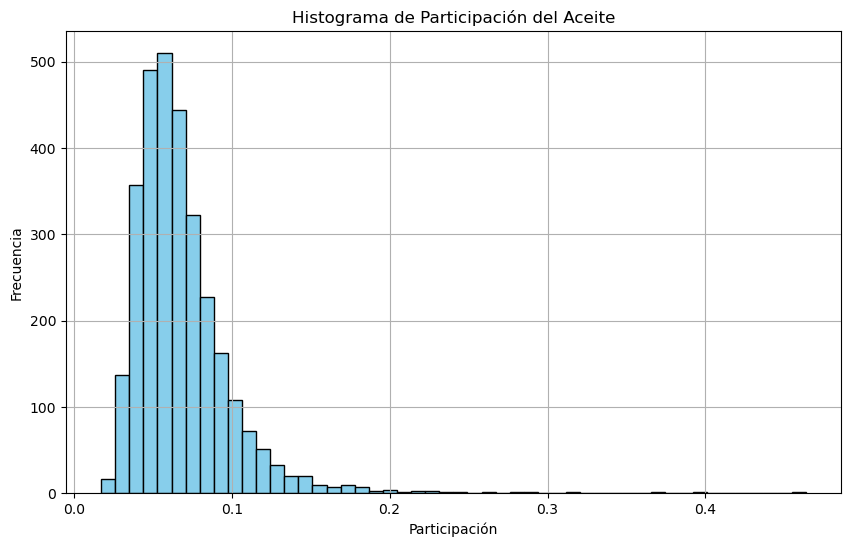

In [26]:
import matplotlib.pyplot as plt

# Filtrar los datos
aux2 = Top_productos[(Top_productos['Orden'] == 1) & (Top_productos['product_item_id'] == '00000021592')]

# Plotear el histograma de la participación
plt.figure(figsize=(10, 6))
plt.hist(aux2['Participacion'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Participación')
plt.ylabel('Frecuencia')
plt.title('Histograma de Participación del Aceite')
plt.grid(True)
plt.show()

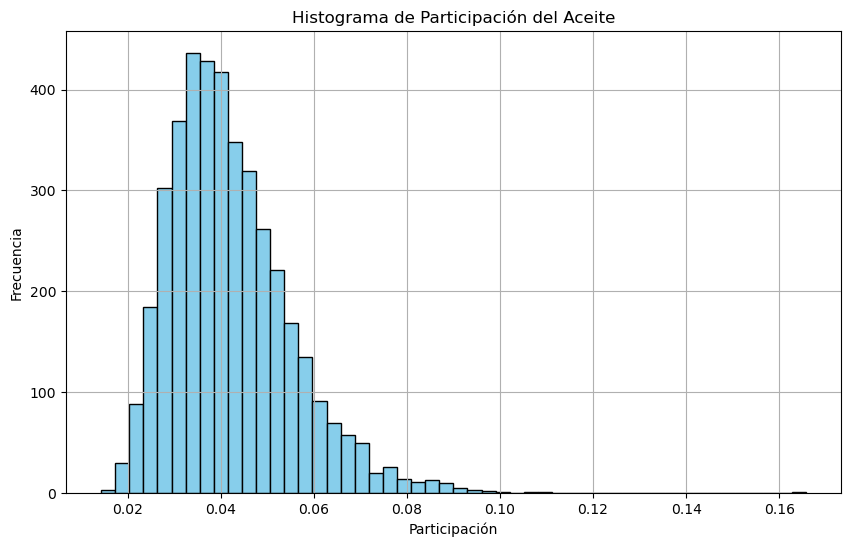

In [27]:
import matplotlib.pyplot as plt

# Filtrar los datos
aux2 = Top_productos[(Top_productos['Orden'] == 2) & (Top_productos['product_item_id'] == '00000021592')]

# Plotear el histograma de la participación
plt.figure(figsize=(10, 6))
plt.hist(aux2['Participacion'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Participación')
plt.ylabel('Frecuencia')
plt.title('Histograma de Participación del Aceite')
plt.grid(True)
plt.show()

In [28]:
Top_productos[(Top_productos['place_id']=='1263') & (Top_productos['product_item_description']!='Canasta IC')].sort_values('Participacion',ascending=False)

,product_item_id,periodo,place_id,itc_company_name_enablement,place_description,precio_producto,unidades_mes,venta_mes,Participacion,Venta_Acum_mes,Orden,product_item_description,product_subcategory
329140,00000975312,2022-11-01,1263,Mass,BUENOS3 TRU MS,4.358942,1862.000,8116.35,0.093171,87112.83,1,Pilsen Trujillo Cerveza Bt 620 Ml,Cerveza
329120,00000975312,2023-02-01,1263,Mass,BUENOS3 TRU MS,4.501981,1979.000,8909.42,0.07653,116417.27,1,Pilsen Trujillo Cerveza Bt 620 Ml,Cerveza
329050,00000975312,2022-12-01,1263,Mass,BUENOS3 TRU MS,4.549652,1524.000,6933.67,0.065065,106565.93,1,Pilsen Trujillo Cerveza Bt 620 Ml,Cerveza
329190,00020107266,2024-04-01,1263,Mass,BUENOS3 TRU MS,7.414782,1376.441,10206.01,0.061437,166122.80,1,Mass Huevo Granel Kg,Huevos
329160,00020107266,2024-05-01,1263,Mass,BUENOS3 TRU MS,7.398633,532.470,3939.55,0.055892,70485.23,1,Mass Huevo Granel Kg,Huevos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329089,00020205643,2023-09-01,1263,Mass,BUENOS3 TRU MS,11.857355,121.000,1434.74,0.008434,170106.43,10,Pacifico Cerveza Pk 6 La 355 Ml,Cerveza
329169,00000959308,2024-05-01,1263,Mass,BUENOS3 TRU MS,5.169825,114.000,589.36,0.008361,70485.23,10,Bell-S Aceite Vegetal Bt900ml,Aceites
329198,00020325528,2024-04-01,1263,Mass,BUENOS3 TRU MS,5.833550,231.000,1347.55,0.008112,166122.80,9,Noble Ph Premium Black 40mts Pq4un,Papeleria Limpieza
329199,00020107467,2024-04-01,1263,Mass,BUENOS3 TRU MS,13.687158,95.000,1300.28,0.007827,166122.80,10,Koperwiek Cerveza Pk 6 Lt 330 Ml,Cerveza


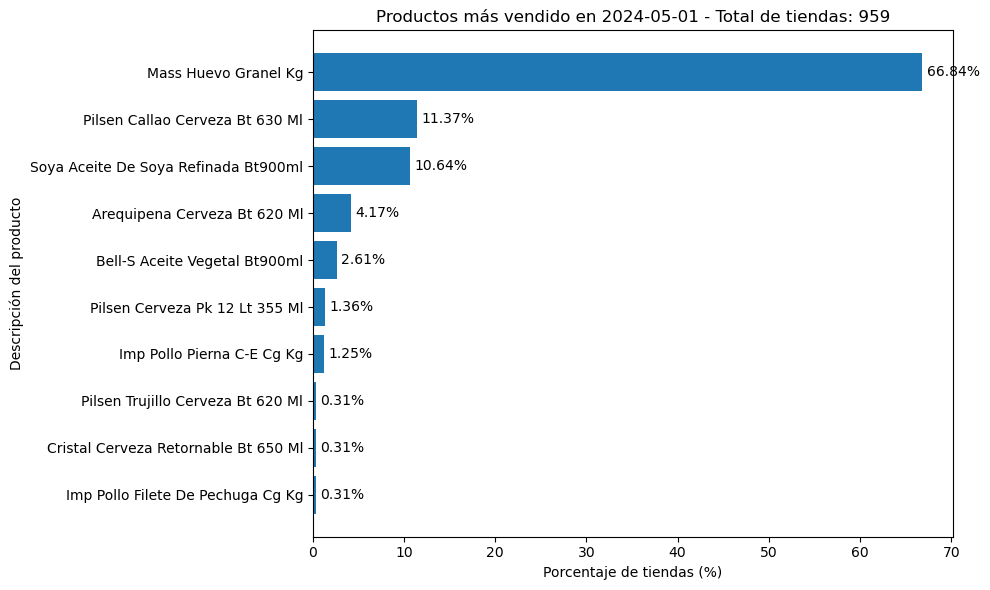

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

productos = Top_productos[(Top_productos['Orden'] == 1) & (Top_productos['product_item_id'] != '99999999999') & (Top_productos['itc_company_name_enablement'] == 'Mass')]
productos_por_mes = productos.groupby(['periodo','product_item_id', 'product_item_description', 'product_subcategory']).size().reset_index(name='count')
meses_unicos = sorted(productos_por_mes['periodo'].unique())

fig, ax = plt.subplots(figsize=(10, 6))
for mes in meses_unicos:
    productos_mes = productos_por_mes[productos_por_mes['periodo'] == mes]
    productos_mas_comunes = productos_mes.sort_values(by='count', ascending=False).head(10)  # Obtener los 10 productos más comunes
    
    total_ocurrencias = productos_mes['count'].sum()

    productos_mas_comunes['percentage'] = (productos_mas_comunes['count'] / total_ocurrencias) * 100
    
    ax.clear()

    ax.barh(productos_mas_comunes['product_item_description'], productos_mas_comunes['percentage'])
    ax.set_xlabel('Porcentaje de tiendas (%)')
    ax.set_ylabel('Descripción del producto')
    ax.set_title(f'Productos más vendido en {pd.to_datetime(mes).strftime("%Y-%m-%d")} - Total de tiendas: {total_ocurrencias}')
    ax.invert_yaxis()  # Invertir el eje y para que el producto más común esté arriba
    
    # Mostrar el valor del porcentaje en cada barra
    for i, percentage in enumerate(productos_mas_comunes['percentage']):
        ax.text(percentage + 0.5, i, f'{percentage:.2f}%', va='center')
    
    plt.tight_layout()
    
    # Mostrar el gráfico actualizado
    display(fig)
    
    # Esperar un momento antes de mostrar el siguiente mes
    time.sleep(0.5)
    
    # Limpiar la salida para actualizar el gráfico con el siguiente mes
    clear_output(wait=True)


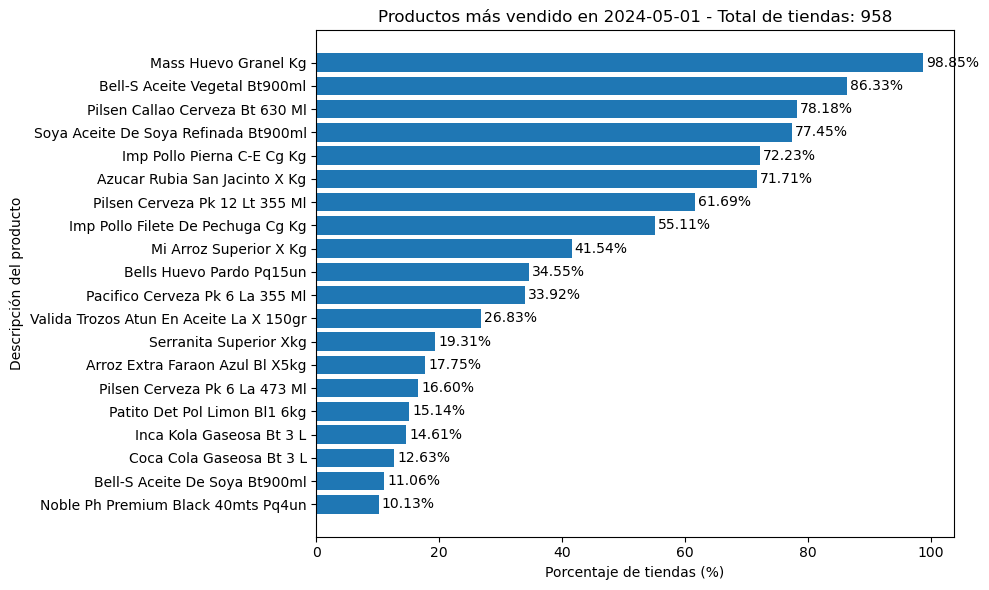

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

productos = Top_productos[(Top_productos['product_item_id'] != '99999999999') & (Top_productos['itc_company_name_enablement'] == 'Mass')]
productos_por_mes = productos.groupby(['periodo','product_item_id', 'product_item_description', 'product_subcategory']).size().reset_index(name='count')

meses_unicos = sorted(productos_por_mes[productos_por_mes['periodo'] != '2023-11-01']['periodo'].unique())

fig, ax = plt.subplots(figsize=(10, 6))
for mes in meses_unicos:
    productos_mes = productos_por_mes[productos_por_mes['periodo'] == mes]
    
    productos_mas_comunes = productos_mes.sort_values(by='count', ascending=False).head(20)  # Obtener los 10 productos más comunes
    
    total_ocurrencias=Top_productos[(Top_productos['periodo']==mes) & (Top_productos['product_item_id'] != '99999999999') & (Top_productos['itc_company_name_enablement'] == 'Mass')].place_id.nunique()


    productos_mas_comunes['percentage'] = (productos_mas_comunes['count'] / total_ocurrencias) * 100

   
    ax.clear()

    ax.barh(productos_mas_comunes['product_item_description'], productos_mas_comunes['percentage'])
    ax.set_xlabel('Porcentaje de tiendas (%)')
    ax.set_ylabel('Descripción del producto')
    ax.set_title(f'Productos más vendido en {pd.to_datetime(mes).strftime("%Y-%m-%d")} - Total de tiendas: {total_ocurrencias}')
    ax.invert_yaxis()  # Invertir el eje y para que el producto más común esté arriba
    
    # Mostrar el valor del porcentaje en cada barra
    for i, percentage in enumerate(productos_mas_comunes['percentage']):
        ax.text(percentage + 0.5, i, f'{percentage:.2f}%', va='center')
    
    plt.tight_layout()
    
    # Mostrar el gráfico actualizado
    display(fig)
    
    # Esperar un momento antes de mostrar el siguiente mes
    time.sleep(0.5)
    
    # Limpiar la salida para actualizar el gráfico con el siguiente mes
    clear_output(wait=True)


In [31]:
Top_productos[Top_productos['periodo']==mes].place_id.nunique()

1091

In [32]:
Top_productos[(Top_productos['product_item_id']=='00020107266') & (Top_productos['place_id']=='M890')].to_csv('Prueba.csv',index=False)#.Participacion.sum()

In [33]:
Top_productos[(Top_productos['periodo']=='2023-11-01') & (Top_productos['product_item_id'] != '99999999999') & (Top_productos['itc_company_name_enablement'] == 'Mass')].place_id.nunique()

841

In [34]:
#.periodo.nunique()#[productos_mes['periodo']=='2023-11-01']
productos_mes = productos_por_mes[productos_por_mes['periodo'] == '2023-11-01']
productos_mas_comunes = productos_mes.sort_values(by='count', ascending=False).head(20)  # Obtener los 10 productos más comunes
total_ocurrencias=Top_productos[(Top_productos['periodo']=='2023-11-01') & (Top_productos['product_item_id'] != '99999999999') & (Top_productos['itc_company_name_enablement'] == 'Mass')].place_id.nunique()
total_ocurrencias


841

In [35]:
productos_mes[productos_mes['product_item_description']=='Mass Huevo Granel Kg']

,periodo,product_item_id,product_item_description,product_subcategory,count
5049,2023-11-01,00020107266,Mass Huevo Granel Kg,Huevos,1494


In [36]:
productos_por_mes[(productos_por_mes['periodo'] == '2023-11-01') & (productos_por_mes['product_item_id']=='00020107266')]

,periodo,product_item_id,product_item_description,product_subcategory,count
5049,2023-11-01,00020107266,Mass Huevo Granel Kg,Huevos,1494


In [37]:
Top_productos[(Top_productos['itc_company_name_enablement'] == 'Mass') & (Top_productos['periodo'] == '2023-11-01')]

,product_item_id,periodo,place_id,itc_company_name_enablement,place_description,precio_producto,unidades_mes,venta_mes,Participacion,Venta_Acum_mes,Orden,product_item_description,product_subcategory
180,00020107266,2023-11-01,M890,Mass,MASS PEDRO 2 BR MS,7.376463,937.010,6911.82,0.047481,145571.20,1,Mass Huevo Granel Kg,Huevos
181,00020008541,2023-11-01,M890,Mass,MASS PEDRO 2 BR MS,4.660000,1189.000,5540.74,0.038062,145571.20,2,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
182,00020107266,2023-11-01,M890,Mass,MASS PEDRO 2 BR MS,7.110506,769.190,5469.33,0.037572,145571.20,3,Mass Huevo Granel Kg,Huevos
183,00020235918,2023-11-01,M890,Mass,MASS PEDRO 2 BR MS,3.328096,1014.550,3376.52,0.023195,145571.20,4,Azucar Rubia San Jacinto X Kg,Azucar
184,00000988971,2023-11-01,M890,Mass,MASS PEDRO 2 BR MS,4.667026,723.000,3374.26,0.023179,145571.20,5,Cristal Cerveza Retornable Bt 650 Ml,Cerveza
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432512,99999999999,2023-11-01,1004,Mass,CONDOR 6 CB MS,25.216459,1012.575,6429.04,0.0,96943.23,1,Canasta IC,Canasta IC
432549,99999999999,2023-11-01,1003,Mass,TAMBO B13 PP MS,25.269220,2852.685,18072.88,0.0,166925.13,1,Canasta IC,Canasta IC
432586,99999999999,2023-11-01,1002,Mass,MERCADO SJL MS,25.824227,1781.505,11875.18,0.0,151698.77,1,Canasta IC,Canasta IC
432623,99999999999,2023-11-01,1001,Mass,CAMINO C5 CB MS,25.204549,1998.582,12779.59,0.0,138564.00,1,Canasta IC,Canasta IC


In [38]:
def Categorias_Vendidas(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
    SELECT *
FROM (
SELECT PLACE_ID,ANIO,product_subcategory,ROW_NUMBER() OVER (PARTITION BY PLACE_ID,ANIO ORDER BY VENTA_ANUAL DESC)ORDEN
FROM (
SELECT place_id,place_description,date_trunc(periodo,year)anio,channel,channel_analytic,itc_company_name_analytic,
 itc_company_name_enablement,product_subcategory,sum(venta_mes)VENTA_ANUAL
    FROM (
    SELECT *,ROW_NUMBER() OVER(PARTITION BY periodo,place_id,channel_analytic,itc_company_name_enablement order by venta_mes desc)Orden
    FROM `inretail-negocios-sd.intercorpretail_mass.Ventas_Diarias_IR_Producto2`
     WHERE  itc_company_name_enablement in ('Mass','Plaza Vea','Vivanda') AND itc_company_name_enablement='Mass' 
     and channel_analytic not like '%ONLINE%'
    )
group by place_id,place_description,date_trunc(periodo,year),channel,channel_analytic,itc_company_name_analytic,itc_company_name_enablement,product_subcategory)
)
PIVOT
(
  MAX(ORDEN) 
  For product_subcategory IN ('Confiteria', 'Jugueteria', 'Conservas', 'Procesados', 'Fideos', 'Pasteleria Seca', 'Cuidado De La Ropa', 'Gaseosas', 'Aguas', 'Sin Hueso', 'Licores', 'Aceites', 'Ferreteria', 'Limpieza', 'Panaderia Industrial', 'Semi-Duros', 'Cerveza', 'Leche Envasada', 'Jugos', 'Cuidado Del Bebe', 'Margarina Y Mantequilla', 'Blandos', 'Helados', 'Maquillaje', 'Lavavajillas', 'Cuidado Del Cabello', 'Cuidado Familiar', 'Especial', 'Menestras', 'Recargas', 'Cocina', 'Chorizo', 'Espumante', 'Alimentos', 'Arroz', 'Yogurt', 'Reposteria', 'Mascotas', 'Papeleria Limpieza', 'Detergente', 'Piqueos', 'Desayunos', 'Azucar', 'Cuidado Bucal', 'Vino', 'Embutidos', 'Perfumeria', 'Bebidas Funcionales', 'Pollo', 'Pescados', 'Reposteria Y Otros', 'Desinfectantes', 'Farmacia', 'Feteados', 'Varios', 'Menaje', 'Mariscos', 'Huevos', 'Bolsas Compostables', 'Estacionales - Aire Libre Y Deport', 'Duros'
)
)
    """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 

def Tiendas_Mass(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
   SELECT distinct codigo_local,local,antiguedad
    FROM `inretail-negocios-sd.intercorpretail_mass.Tabla_Estacionalidad_Prueba`
    """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 

def Categorias_Vendidas_2(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
   SELECT place_id,place_description,date_trunc(periodo,year)anio,channel,channel_analytic,itc_company_name_analytic,
 itc_company_name_enablement,product_subcategory,sum(venta_mes)VENTA_ANUAL
    FROM (
    SELECT *,ROW_NUMBER() OVER(PARTITION BY periodo,place_id,channel_analytic,itc_company_name_enablement order by venta_mes desc)Orden
    FROM `inretail-negocios-sd.intercorpretail_mass.Ventas_Diarias_IR_Producto2`
     WHERE  itc_company_name_enablement in ('Mass','Plaza Vea','Vivanda') AND itc_company_name_enablement='Mass' 
     and channel_analytic not like '%ONLINE%'
    )
group by place_id,place_description,date_trunc(periodo,year),channel,channel_analytic,itc_company_name_analytic,itc_company_name_enablement,product_subcategory
"""
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 


def Entorno_Mass(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
   SELECT *
        FROM inretail-negocios-sd.intercorpretail_mass.Competidores_Tiendas_Mass
        """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 

In [39]:
Categorioas_Mass=Categorias_Vendidas_2(Llave)
Categorioas_Mass

,place_id,place_description,anio,channel,channel_analytic,itc_company_name_analytic,itc_company_name_enablement,product_subcategory,VENTA_ANUAL
0,M373,B AIRES 4 PP MS,2021-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Fondos,1713.33
1,M380,RECAVAR11 SU MS,2018-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Bebidas,563.34
2,M646,RUISEÑORE3SA MS,2019-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Bebidas,348.89
3,M304,JMORALES SJM MS,2019-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Bebidas,816.60
4,M494,CORALINA6SJL MS,2018-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Bebidas,391.21
...,...,...,...,...,...,...,...,...,...
326500,1589,EDEN H1 AQP MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Estacionales - Aire Libre Y Deport,63.61
326501,M755,BELAUNDE 11 CO MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Estacionales - Aire Libre Y Deport,433.88
326502,M525,EUCALIPTO9SA MS,2018-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Estacionales - Aire Libre Y Deport,177.38
326503,1155,IZAGUI11 LO MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Estacionales - Aire Libre Y Deport,220.53


In [40]:
aux_categorioas_mass=Categorioas_Mass.groupby(['place_id','anio'])[['VENTA_ANUAL']].sum().reset_index()
aux_categorioas_mass

,place_id,anio,VENTA_ANUAL
0,1000,2021-01-01,609967.20
1,1000,2022-01-01,1187319.16
2,1000,2023-01-01,1523945.07
3,1000,2024-01-01,625556.40
4,1001,2021-01-01,592219.90
...,...,...,...
4409,M890,2020-01-01,9.32
4410,M890,2021-01-01,848080.47
4411,M890,2022-01-01,1421233.15
4412,M890,2023-01-01,1694031.27


In [41]:
aux_categorioas_mass2=pd.merge(Categorioas_Mass,aux_categorioas_mass,on=['place_id','anio'],how='left')
aux_categorioas_mass2['participacion']=aux_categorioas_mass2['VENTA_ANUAL_x']/aux_categorioas_mass2['VENTA_ANUAL_y']
aux_categorioas_mass2['anio'] = pd.to_datetime(aux_categorioas_mass2['anio'])

In [42]:
# aux_categorioas_mass3=aux_categorioas_mass2[aux_categorioas_mass2['anio']=='2023-01-01']
# aux_categorioas_mass3.pivot('product_subcategory','place_id','participacion')
aux_categorioas_provincia=aux_categorioas_mass2[aux_categorioas_mass2['place_description'].str.contains('TRU MS|PIU MS|HYO MS|CHB MS|CIX MS')]
aux_categorioas_provincia

,place_id,place_description,anio,channel,channel_analytic,itc_company_name_analytic,itc_company_name_enablement,product_subcategory,VENTA_ANUAL_x,VENTA_ANUAL_y,participacion
157,1456,CHULUCA 1 PIU MS,2023-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Textil Hogar,121.35,828060.20,0.000147
161,1699,PUNO3 PIU MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Otras Aves,349.15,389463.97,0.000896
181,1268,MOCHE8 TRU MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Otras Aves,659.59,681185.36,0.000968
185,1623,ALAMEDA 2 TRU MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Otras Aves,620.18,608437.37,0.001019
263,1598,BOLOGNE 4 TRU MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Otras Aves,142.22,698878.66,0.000203
...,...,...,...,...,...,...,...,...,...,...,...
326401,1470,GRAU 1 TRU MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Estacionales - Aire Libre Y Deport,184.15,808862.49,0.000228
326458,1447,INCAS 4� TRU MS,2024-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Estacionales - Aire Libre Y Deport,203.17,757184.79,0.000268
326469,1373,22FEB7 TRU MS,2023-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Estacionales - Aire Libre Y Deport,353.76,831629.78,0.000425
326473,1386,29 DIC 4 TRU MS,2023-01-01,VENTA POS -FISICO,PRESENCIAL,PLAZA VEA,Mass,Estacionales - Aire Libre Y Deport,312.34,1414002.75,0.000221


In [43]:
Tiendas_Mass_A=Tiendas_Mass(Llave)

aux_categorioas_mass2=aux_categorioas_mass2[aux_categorioas_mass2['anio']=='2023-01-01']
aux_categorioas_mass22=aux_categorioas_mass2.pivot_table(values='participacion', index='place_id', columns='product_subcategory').reset_index()
aux_categorioas_mass22=aux_categorioas_mass22.fillna(0)
aux_categorioas_mass22=aux_categorioas_mass22[aux_categorioas_mass22['place_id'].isin(list(Tiendas_Mass_A[Tiendas_Mass_A['antiguedad']>13].codigo_local.unique()))==True]
aux_categorioas_mass22

product_subcategory,place_id,Accesorios,Accesorios Del Hogar,Accesorios Moda,Aceites,Aguas,Alimentos,Alimentos De Bebes,Arroz,Audifonos,...,Varios,Vestuario,Vestuario Beba,Vestuario Bebo,Vestuario Junior,Vestuario Junior F,Vestuario Niña,Vestuario Niño,Vino,Yogurt
0,1000,0.0,0.000578,0.0,0.045162,0.016089,0.014538,0.000147,0.038069,0.000090,...,0.002116,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.011223,0.016937
1,1001,0.0,0.000304,0.0,0.057746,0.025075,0.015932,0.000139,0.028595,0.000172,...,0.002550,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.007577,0.027972
2,1002,0.0,0.000304,0.0,0.105875,0.016999,0.011832,0.000093,0.051991,0.000117,...,0.002525,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.009343,0.024185
3,1003,0.0,0.000500,0.0,0.093460,0.020504,0.011721,0.000198,0.037383,0.000029,...,0.002379,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.007799,0.022069
4,1004,0.0,0.000693,0.0,0.066709,0.021306,0.016040,0.000186,0.032355,0.000049,...,0.003502,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.008946,0.020431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,M885,0.0,0.000256,0.0,0.052685,0.022902,0.017821,0.000000,0.047814,0.000000,...,0.000924,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.008479,0.018138
910,M886,0.0,0.000588,0.0,0.067054,0.025958,0.017549,0.000102,0.045555,0.000034,...,0.003707,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.010542,0.020035
911,M888,0.0,0.000929,0.0,0.039030,0.018697,0.008367,0.000095,0.040804,0.000176,...,0.004453,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.007657,0.016394
912,M889,0.0,0.000512,0.0,0.088990,0.020253,0.013300,0.000238,0.050761,0.000046,...,0.001393,0.0,0.0,4.982395e-09,0.0,0.0,0.0,0.0,0.008676,0.016033


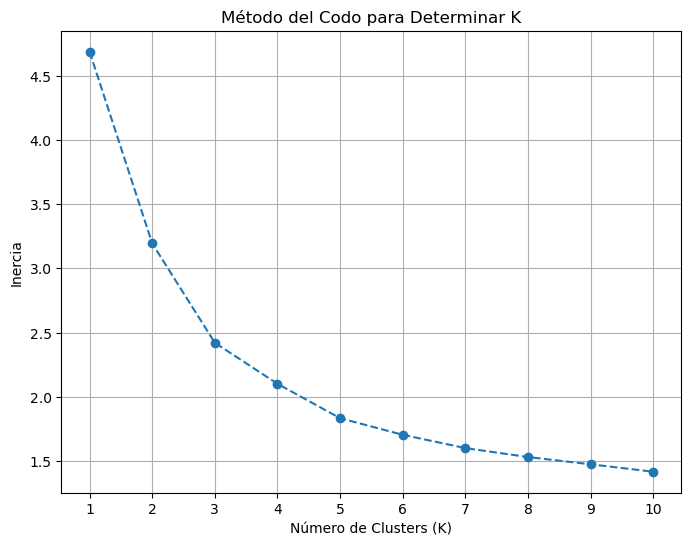

In [44]:
# Calcula la inercia para diferentes valores de K
from sklearn.cluster import KMeans
import pandas as pd

inertia = []
for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(aux_categorioas_mass22.drop(['place_id','Accesorios'], axis=1))
    inertia.append(kmeans.inertia_)

# Visualiza la curva de codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar K')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [45]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=10)
kmeans.fit(aux_categorioas_mass22.drop(['place_id'],axis=1))

KMeans(n_clusters=10)

In [46]:
aux_categorioas_mass22['cluster'] = kmeans.labels_
aux_categorioas_mass22

product_subcategory,place_id,Accesorios,Accesorios Del Hogar,Accesorios Moda,Aceites,Aguas,Alimentos,Alimentos De Bebes,Arroz,Audifonos,...,Vestuario,Vestuario Beba,Vestuario Bebo,Vestuario Junior,Vestuario Junior F,Vestuario Niña,Vestuario Niño,Vino,Yogurt,cluster
0,1000,0.0,0.000578,0.0,0.045162,0.016089,0.014538,0.000147,0.038069,0.000090,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.011223,0.016937,1
1,1001,0.0,0.000304,0.0,0.057746,0.025075,0.015932,0.000139,0.028595,0.000172,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.007577,0.027972,5
2,1002,0.0,0.000304,0.0,0.105875,0.016999,0.011832,0.000093,0.051991,0.000117,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.009343,0.024185,5
3,1003,0.0,0.000500,0.0,0.093460,0.020504,0.011721,0.000198,0.037383,0.000029,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.007799,0.022069,2
4,1004,0.0,0.000693,0.0,0.066709,0.021306,0.016040,0.000186,0.032355,0.000049,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.008946,0.020431,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,M885,0.0,0.000256,0.0,0.052685,0.022902,0.017821,0.000000,0.047814,0.000000,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.008479,0.018138,1
910,M886,0.0,0.000588,0.0,0.067054,0.025958,0.017549,0.000102,0.045555,0.000034,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.010542,0.020035,2
911,M888,0.0,0.000929,0.0,0.039030,0.018697,0.008367,0.000095,0.040804,0.000176,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.007657,0.016394,7
912,M889,0.0,0.000512,0.0,0.088990,0.020253,0.013300,0.000238,0.050761,0.000046,...,0.0,0.0,4.982395e-09,0.0,0.0,0.0,0.0,0.008676,0.016033,3


In [47]:
aux_categorioas_mass22[aux_categorioas_mass22['Aceites']>0.05].groupby('cluster')[['place_id']].count()

product_subcategory,place_id
cluster,
0,35
1,86
2,111
3,90
4,3
5,84
6,5
7,30
8,46


In [48]:
aux_categorioas_mass22[aux_categorioas_mass22['Cerveza']>0.15].groupby('cluster')[['place_id']].count()

product_subcategory,place_id
cluster,
0,12
4,19
5,26
7,58


In [49]:
aux_categorioas_mass22[aux_categorioas_mass22['Huevos']>=0.08].groupby('cluster')[['place_id']].count()

product_subcategory,place_id
cluster,
0,1
1,58
2,4
3,91
5,5
6,45
7,1
8,1
9,82


In [50]:
aux_categorioas_mass22.to_excel('Clusters_Mass.xlsx',index=False)

In [51]:
Tiendas_Mass_A=Tiendas_Mass(Llave)
Ventas_Tiendas=Categorias_Vendidas(Llave)

In [52]:
Ventas_Tiendas['ANIO'] = pd.to_datetime(Ventas_Tiendas['ANIO'])
Ventas_Tiendas_23=Ventas_Tiendas[Ventas_Tiendas['ANIO']=='2023-01-01']
Ventas_Tiendas_23=Ventas_Tiendas_23[Ventas_Tiendas_23['PLACE_ID'].isin(list(Tiendas_Mass_A[Tiendas_Mass_A['antiguedad']>13].codigo_local.unique()))==True]
Ventas_Tiendas_23=Ventas_Tiendas_23.fillna(-99999)

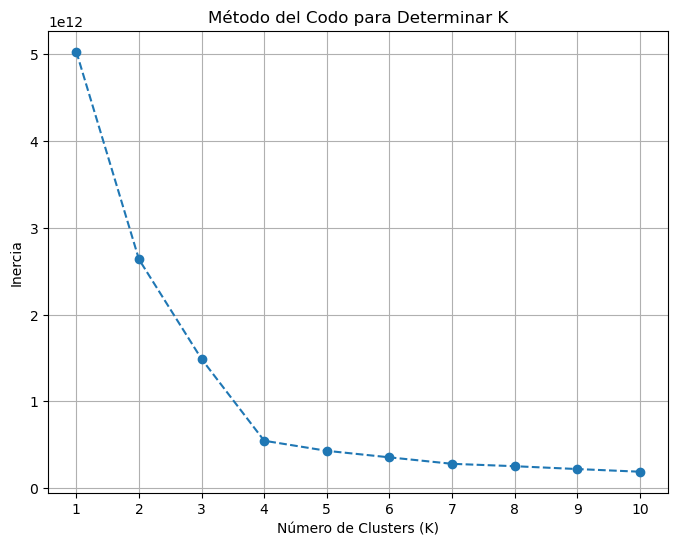

In [53]:
aux=Ventas_Tiendas_23.drop(['PLACE_ID', 'ANIO'], axis=1)
# Calcula la inercia para diferentes valores de K
inertia = []
for k in range(1, 11):  # Prueba con un rango de valores de K de 1 a 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(aux)
    inertia.append(kmeans.inertia_)

# Visualiza la curva de codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar K')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [54]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=20)
kmeans.fit(Ventas_Tiendas_23.drop(['PLACE_ID','ANIO'],axis=1))

Ventas_Tiendas_23['cluster'] = kmeans.labels_

# Visualiza los resultados
print(Ventas_Tiendas_23.head())

    PLACE_ID       ANIO  Confiteria  Jugueteria  Conservas  Procesados  \
262     1347 2023-01-01           7          35          9      -99999   
271     1384 2023-01-01           2          37         10      -99999   
319     1349 2023-01-01           4          39         15      -99999   
332     1404 2023-01-01           3          39         13          63   
358     1467 2023-01-01           6          37         15          64   

     Fideos  Pasteleria Seca  Cuidado De La Ropa  Gaseosas  ...  Farmacia  \
262      21           -99999                  25        10  ...        41   
271      27               54                  22        11  ...        40   
319       9           -99999                  22        12  ...        45   
332       9           -99999                  22        15  ...        42   
358      10           -99999                  20        17  ...        44   

     Feteados  Varios  Menaje  Mariscos  Huevos  Bolsas Compostables  \
262    -99999      4

In [55]:
Ventas_Tiendas_23[Ventas_Tiendas_23['cluster']==0].iloc[0].T.head(50)

PLACE_ID                                  M868
ANIO                       2023-01-01 00:00:00
Confiteria                                   5
Jugueteria                                  50
Conservas                                   12
Procesados                                  47
Fideos                                      25
Pasteleria Seca                             49
Cuidado De La Ropa                          33
Gaseosas                                     3
Aguas                                       18
Sin Hueso                                   57
Licores                                      6
Aceites                                      7
Ferreteria                                  71
Limpieza                                    45
Panaderia Industrial                        16
Semi-Duros                                  53
Cerveza                                      2
Leche Envasada                               4
Jugos                                       20
Cuidado Del B

In [56]:
Ventas_Tiendas_23[Ventas_Tiendas_23['Cerveza']==1].groupby('cluster').count()

,PLACE_ID,ANIO,Confiteria,Jugueteria,Conservas,Procesados,Fideos,Pasteleria Seca,Cuidado De La Ropa,Gaseosas,...,Desinfectantes,Farmacia,Feteados,Varios,Menaje,Mariscos,Huevos,Bolsas Compostables,Estacionales - Aire Libre Y Deport,Duros
cluster,,,,,,,,,,,,,,,,,,,,,
0,286,286,286,286,286,286,286,286,286,286,...,286,286,286,286,286,286,286,286,286,286
1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2,84,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
3,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
4,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
5,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [57]:
Ventas_Tiendas_23[Ventas_Tiendas_23['Aceites']<3].groupby('cluster').count()

,PLACE_ID,ANIO,Confiteria,Jugueteria,Conservas,Procesados,Fideos,Pasteleria Seca,Cuidado De La Ropa,Gaseosas,...,Desinfectantes,Farmacia,Feteados,Varios,Menaje,Mariscos,Huevos,Bolsas Compostables,Estacionales - Aire Libre Y Deport,Duros
cluster,,,,,,,,,,,,,,,,,,,,,
0,195,195,195,195,195,195,195,195,195,195,...,195,195,195,195,195,195,195,195,195,195
1,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
3,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
4,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
5,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [58]:
Ventas_Tiendas_23[Ventas_Tiendas_23['Huevos']==1].groupby('cluster').count()

,PLACE_ID,ANIO,Confiteria,Jugueteria,Conservas,Procesados,Fideos,Pasteleria Seca,Cuidado De La Ropa,Gaseosas,...,Desinfectantes,Farmacia,Feteados,Varios,Menaje,Mariscos,Huevos,Bolsas Compostables,Estacionales - Aire Libre Y Deport,Duros
cluster,,,,,,,,,,,,,,,,,,,,,
0,179,179,179,179,179,179,179,179,179,179,...,179,179,179,179,179,179,179,179,179,179
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
4,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
10,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
12,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
16,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [59]:
Ventas_Tiendas_23[Ventas_Tiendas_23['cluster']==0]

,PLACE_ID,ANIO,Confiteria,Jugueteria,Conservas,Procesados,Fideos,Pasteleria Seca,Cuidado De La Ropa,Gaseosas,...,Farmacia,Feteados,Varios,Menaje,Mariscos,Huevos,Bolsas Compostables,Estacionales - Aire Libre Y Deport,Duros,cluster
1416,M868,2023-01-01,5,50,12,47,25,49,33,3,...,52,41,51,38,72,11,54,-99999,67,0
1526,1028,2023-01-01,5,48,15,47,17,50,32,7,...,58,45,52,44,69,2,55,-99999,64,0
1534,M789,2023-01-01,6,47,12,51,13,52,32,8,...,57,45,48,46,69,3,49,-99999,63,0
1558,1379,2023-01-01,6,54,13,52,17,57,31,8,...,51,48,49,44,62,2,50,-99999,63,0
1592,M502,2023-01-01,5,45,19,48,15,47,32,4,...,55,41,52,46,71,2,51,-99999,61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4085,1043,2023-01-01,8,40,16,51,15,55,30,6,...,63,39,50,46,67,3,57,-99999,66,0
4109,M594,2023-01-01,4,50,16,52,12,58,24,7,...,59,38,57,42,65,22,63,-99999,69,0
4126,1266,2023-01-01,3,51,28,48,27,54,23,5,...,55,38,45,21,71,30,53,-99999,72,0
4138,1045,2023-01-01,6,51,16,56,17,50,30,9,...,58,42,48,32,61,7,59,-99999,74,0


In [60]:
Ventas_Tiendas_23[Ventas_Tiendas_23['PLACE_ID']=='1223']

,PLACE_ID,ANIO,Confiteria,Jugueteria,Conservas,Procesados,Fideos,Pasteleria Seca,Cuidado De La Ropa,Gaseosas,...,Farmacia,Feteados,Varios,Menaje,Mariscos,Huevos,Bolsas Compostables,Estacionales - Aire Libre Y Deport,Duros,cluster
3425,1223,2023-01-01,3,47,16,60,19,52,26,2,...,56,40,54,23,64,36,61,-99999,75,0


In [61]:
Top_productos[(Top_productos['place_id']=='1223') & (Top_productos['Orden']==1)]

,product_item_id,periodo,place_id,itc_company_name_enablement,place_description,precio_producto,unidades_mes,venta_mes,Participacion,Venta_Acum_mes,Orden,product_item_description,product_subcategory
335000,00020008541,2024-02-01,1223,Mass,TRIUNFOB3AQP MS,5.246135,1423.000,7465.25,0.030915,241478.63,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335010,00020008541,2024-04-01,1223,Mass,TRIUNFOB3AQP MS,5.229676,1204.000,6296.53,0.025567,246275.03,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335020,00020008541,2023-10-01,1223,Mass,TRIUNFOB3AQP MS,4.497547,5829.000,26216.20,0.097752,268191.95,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335030,00020008541,2024-03-01,1223,Mass,TRIUNFOB3AQP MS,5.212749,1393.000,7261.36,0.026351,275567.39,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335040,00020008541,2023-03-01,1223,Mass,TRIUNFOB3AQP MS,4.590174,3797.000,17428.89,0.126604,137664.75,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335050,00020008541,2023-08-01,1223,Mass,TRIUNFOB3AQP MS,4.537727,5336.000,24213.31,0.097883,247369.14,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335060,00020008541,2023-06-01,1223,Mass,TRIUNFOB3AQP MS,4.553492,3362.000,15308.84,0.080084,191159.59,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335070,00020008541,2023-07-01,1223,Mass,TRIUNFOB3AQP MS,4.534801,4403.000,19966.73,0.091515,218180.77,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335080,00020008541,2024-01-01,1223,Mass,TRIUNFOB3AQP MS,5.232123,1733.000,9067.27,0.036919,245598.31,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza
335090,00020008541,2022-12-01,1223,Mass,TRIUNFOB3AQP MS,4.416822,4009.000,17707.04,0.132638,133499.24,1,Pilsen Callao Cerveza Bt 630 Ml,Cerveza


In [62]:
Entornos=Entorno_Mass(Llave)
Entornos

,codigo_local,local,APERTURA,status,venta_mass_23,VTA_PROM_MES,Rango_Venta,meses_2023,GRUPO_ANALISIS,TIPO_TIENDA,...,Porc_Pob_D,Porc_Pob_E,CantVias_4m,POI_Total_75m,POI_Comercial_75m,Venta_Farma_100M,Venta_Farma_200m,Venta_Farma_300M,Venta_Farma_400M,Venta_Farma_500M
0,1880,Martin21 HUAU MS,202404,Activo,NaN,NaN,1,<NA>,Provincia,None,...,0.369371,0.000000,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
1,1927,Octubre1N SMP MS,202405,Activo,NaN,NaN,1,<NA>,Provincia,None,...,0.000000,0.002636,27,14,4,NaN,NaN,NaN,NaN,NaN
2,1370,Jardin B3 SJL MS,202212,Activo,1393295.84,116107.986667,3,12,SJL,REGULAR,...,0.117485,0.035124,37,1,1,NaN,NaN,NaN,NaN,NaN
3,1043,Circun P SJL MS,202108,Activo,1726039.03,143836.585833,4,12,SJL,REGULAR,...,0.252181,0.000848,36,4,1,NaN,NaN,NaN,NaN,NaN
4,1182,CampoyC2 SJL MS,202205,Activo,1023825.17,85318.764167,2,12,SJL,REGULAR,...,0.032461,0.000000,24,5,3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,1599,Cahuas5 HUA MS,202307,Activo,1146414.11,191069.018333,6,6,Corredor Norte,REGULAR,...,0.079035,0.000000,<NA>,<NA>,<NA>,0.000000e+00,1.649268e+06,9.790796e+06,9.790796e+06,1.229833e+07
986,1048,Lima 11 Barr MS,202111,Activo,3554147.13,296178.927500,6,12,Corredor Norte,PLUS,...,0.399570,0.000000,<NA>,<NA>,<NA>,1.372145e+06,3.572453e+06,1.177799e+07,1.416099e+07,1.503213e+07
987,1007,Derecha 3 HUA MS,202105,Activo,2240782.07,186731.839167,5,12,Corredor Norte,REGULAR,...,0.053519,0.000000,<NA>,44,25,6.110570e+06,6.110570e+06,1.229833e+07,1.229833e+07,1.229833e+07
988,1022,Bologne BARR MS,202106,Activo,1820303.05,151691.920833,4,12,Corredor Norte,REGULAR,...,0.049857,0.000000,<NA>,48,20,0.000000e+00,8.068192e+06,8.939328e+06,1.132232e+07,1.132232e+07


In [63]:
aux_categorioas_provincia2=aux_categorioas_provincia[aux_categorioas_provincia['anio']=='2024-01-01']
aux_provincias3_fi = aux_categorioas_provincia2.pivot(index=['place_id','place_description'], columns='product_subcategory', values='participacion').reset_index()

In [64]:
aux_provincias3_fi

product_subcategory,place_id,place_description,Accesorios Del Hogar,Aceites,Aguas,Alimentos,Alimentos De Bebes,Arroz,Audifonos,Azucar,...,Semi-Duros,Sin Hueso,Textil Hogar,Tradicional,Varios,Vestuario,Vestuario Beba,Vestuario Bebo,Vino,Yogurt
0,1263,BUENOS3 TRU MS,0.001260,0.050538,0.018671,0.012264,0.000492,0.026557,0.000213,0.017911,...,0.003097,0.000780,NaN,0.000390,0.002626,NaN,NaN,NaN,0.007739,0.021464
1,1264,PALMA8 TRU MS,0.001266,0.061029,0.018373,0.015234,0.000807,0.026139,0.000115,0.015184,...,0.003117,0.000998,NaN,0.000427,0.000731,NaN,NaN,NaN,0.008326,0.029109
2,1265,MANSI16 TRU MS,0.001452,0.056369,0.019178,0.009964,0.000587,0.032471,0.000347,0.018947,...,0.001448,0.001305,NaN,0.000347,0.002793,NaN,NaN,NaN,0.007891,0.016730
3,1266,CARRION1 TRU MS,0.001284,0.078619,0.017048,0.011726,0.000816,0.015699,0.000108,0.010918,...,0.003881,0.000619,0.000435,0.000240,0.003533,NaN,NaN,NaN,0.006713,0.037113
4,1268,MOCHE8 TRU MS,0.001091,0.079367,0.017053,0.013840,0.000539,0.025621,0.000222,0.015382,...,0.002155,0.001288,NaN,0.000469,0.002252,NaN,NaN,NaN,0.008729,0.021325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,1935,LIMA2 CIX MS,0.001367,0.072168,0.011210,NaN,0.001830,0.031983,0.001812,0.021649,...,NaN,NaN,NaN,NaN,0.002130,NaN,NaN,NaN,0.023633,NaN
166,1938,ALAMOSA1 CHB MS,0.003730,0.038346,0.015120,NaN,0.002446,0.019265,NaN,0.014194,...,NaN,NaN,NaN,NaN,0.000229,NaN,NaN,NaN,0.012597,NaN
167,1939,SAUCES24 CIX MS,0.001495,0.036075,0.012710,0.002543,0.000719,0.040083,0.000545,0.020107,...,NaN,NaN,NaN,NaN,0.001903,NaN,NaN,NaN,0.013897,NaN
168,1947,JULIO8 HYO MS,0.000291,0.094830,0.012905,0.002847,0.001959,0.043459,NaN,0.030781,...,NaN,NaN,NaN,0.000184,0.001810,NaN,NaN,NaN,0.008193,NaN


In [65]:
pd.merge(aux_provincias3_fi,Entornos,right_on='codigo_local',left_on='place_id')#.to_excel('Entorno_Provincias.xlsx')

,place_id,place_description,Accesorios Del Hogar,Aceites,Aguas,Alimentos,Alimentos De Bebes,Arroz,Audifonos,Azucar,...,Porc_Pob_D,Porc_Pob_E,CantVias_4m,POI_Total_75m,POI_Comercial_75m,Venta_Farma_100M,Venta_Farma_200m,Venta_Farma_300M,Venta_Farma_400M,Venta_Farma_500M
0,1263,BUENOS3 TRU MS,0.001260,0.050538,0.018671,0.012264,0.000492,0.026557,0.000213,0.017911,...,0.028402,0.000000,<NA>,6,2,0.000000e+00,2.333257e+06,2.333257e+06,2.333257e+06,3.562643e+06
1,1264,PALMA8 TRU MS,0.001266,0.061029,0.018373,0.015234,0.000807,0.026139,0.000115,0.015184,...,0.121820,0.000080,<NA>,17,11,4.372588e+06,4.372588e+06,4.372588e+06,4.372588e+06,4.372588e+06
2,1265,MANSI16 TRU MS,0.001452,0.056369,0.019178,0.009964,0.000587,0.032471,0.000347,0.018947,...,0.000484,0.000000,<NA>,33,14,0.000000e+00,0.000000e+00,0.000000e+00,2.868140e+06,6.365135e+06
3,1266,CARRION1 TRU MS,0.001284,0.078619,0.017048,0.011726,0.000816,0.015699,0.000108,0.010918,...,0.063052,0.000552,<NA>,30,21,4.114373e+06,4.114373e+06,4.114373e+06,4.114373e+06,5.268683e+06
4,1268,MOCHE8 TRU MS,0.001091,0.079367,0.017053,0.013840,0.000539,0.025621,0.000222,0.015382,...,0.019204,0.000000,<NA>,10,5,0.000000e+00,0.000000e+00,2.489948e+06,2.489948e+06,2.489948e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,1935,LIMA2 CIX MS,0.001367,0.072168,0.011210,NaN,0.001830,0.031983,0.001812,0.021649,...,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
166,1938,ALAMOSA1 CHB MS,0.003730,0.038346,0.015120,NaN,0.002446,0.019265,NaN,0.014194,...,0.000578,0.000000,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
167,1939,SAUCES24 CIX MS,0.001495,0.036075,0.012710,0.002543,0.000719,0.040083,0.000545,0.020107,...,0.000000,0.000000,<NA>,2,2,NaN,NaN,NaN,NaN,NaN
168,1947,JULIO8 HYO MS,0.000291,0.094830,0.012905,0.002847,0.001959,0.043459,NaN,0.030781,...,NaN,NaN,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN


In [66]:
Clusters=Entornos[Entornos['codigo_local'].isin(list(aux_provincias3_fi.place_id.unique()))==True]
Clusters=Clusters.drop(['Venta_Farma_200m', 'Venta_Farma_300M', 'Venta_Farma_400M','Venta_Farma_500M','Colegios_50m', 'Colegios_100m',
       'Colegios_150m', 'Colegios_200m','Salud_50m', 'Salud_100m', 'Salud_200m',
       'Salud_300m', 'Salud_posta_50m', 'Salud_posta_100m', 'Salud_posta_200m',
       'Salud_posta_300m','Pob_6m', 'Pob_A', 'Pob_B', 'Pob_C', 'Pob_D', 'Pob_E',
       'Porc_Pob_A', 'Porc_Pob_B', 'Porc_Pob_C', 'Porc_Pob_D', 'Porc_Pob_E'],axis=1)
Clusters=Clusters.fillna(-99999)

In [67]:
Clusters.columns

Index(['codigo_local', 'local', 'APERTURA', 'status', 'venta_mass_23',
       'VTA_PROM_MES', 'Rango_Venta', 'meses_2023', 'GRUPO_ANALISIS',
       'TIPO_TIENDA', 'antiguedad', 'Mercados_100m', 'Mercados_200m',
       'Mercados_300m', 'Mercados_400m', 'Puestos_Mercados_100m',
       'Puestos_Mercados_200m', 'Puestos_Mercados_300m',
       'Puestos_Mercados_400m', 'CODIGO_LOCAL_2', 'Competidores_100M',
       'Competidores_200M', 'Competidores_300M', 'Competidores_400M',
       'Competidores_500M', 'Tottus_100M', 'Tottus_200M', 'Tottus_300M',
       'Tottus_400M', 'Tottus_500M', 'Metro_100M', 'Metro_200M', 'Metro_300M',
       'Metro_400M', 'Metro_500M', 'Wong_100M', 'Wong_200M', 'Wong_300M',
       'Wong_400M', 'Wong_500M', 'HB_100M', 'HB_200M', 'HB_300M', 'HB_400M',
       'HB_500M', 'PV_100M', 'PV_200M', 'PV_300M', 'PV_400M', 'PV_500M',
       'Makro_100M', 'Makro_200M', 'Makro_300M', 'Makro_400M', 'Makro_500M',
       'Mass_100M', 'Mass_200M', 'Mass_300M', 'Mass_400M', 'Mass_500M',


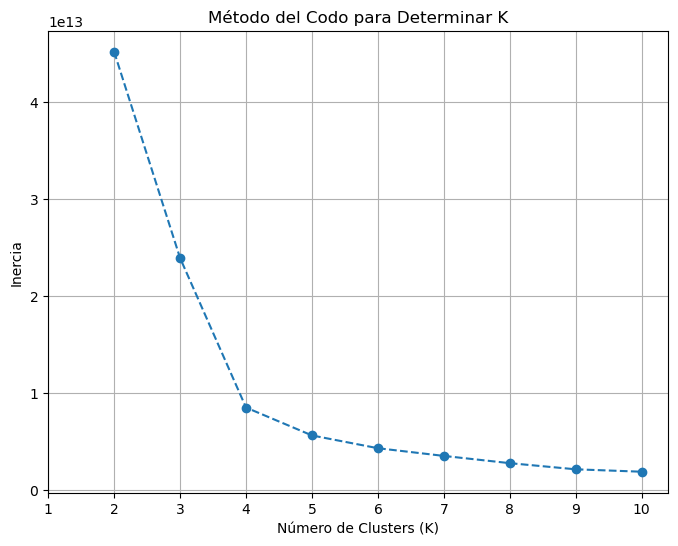

In [68]:
# Calcula la inercia para diferentes valores de K
inertia = []
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(Clusters.drop(['codigo_local','local','APERTURA','meses_2023','antiguedad','venta_mass_23','VTA_PROM_MES','Rango_Venta','status','GRUPO_ANALISIS','CODIGO_LOCAL_2','Tienda','TIPO_TIENDA'], axis=1))
    inertia.append(kmeans.inertia_)

# Visualiza la curva de codo
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar K')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [69]:
pip list

Package                       VersionNote: you may need to restart the kernel to use updated packages.

----------------------------- ---------------
2captcha-python               1.2.2
absl-py                       1.4.0
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.11.3
anaconda-navigator            2.4.2
anaconda-project              0.11.1
ansi2html                     1.8.0
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout   

In [70]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=4)
kmeans.fit(Clusters.drop(['codigo_local','local','APERTURA','meses_2023','antiguedad','venta_mass_23','VTA_PROM_MES','Rango_Venta','status','GRUPO_ANALISIS','CODIGO_LOCAL_2','Tienda','TIPO_TIENDA'], axis=1))

Clusters['cluster'] = kmeans.labels_

In [71]:
Clusters[Clusters['GRUPO_ANALISIS']=='CHICLAYO']

,codigo_local,local,APERTURA,status,venta_mass_23,VTA_PROM_MES,Rango_Venta,meses_2023,GRUPO_ANALISIS,TIPO_TIENDA,...,Farma_200M,Farma_300M,Farma_400M,Farma_500M,Tienda,CantVias_4m,POI_Total_75m,POI_Comercial_75m,Venta_Farma_100M,cluster
239,2004,Raul129 CIX MS,202405,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,-99999,...,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999.0,3
240,1939,Sauces24 CIX MS,202404,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,-99999,...,-99999,-99999,-99999,-99999,Sauces24 CIX MS,-99999,2,2,-99999.0,3
241,1863,TrebolesM3 CIX MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,REGULAR,...,0,0,0,1,TrebolesM3 CIX MS,-99999,20,14,-99999.0,1
242,1911,Viru6 CIX MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,REGULAR,...,0,1,1,1,Viru6 CIX MS,-99999,6,2,-99999.0,1
243,1843,Grau7 CIX MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,REGULAR,...,1,1,1,1,Grau7 CIX MS,-99999,7,3,-99999.0,1
244,1837,Jose7 CIX MS,202402,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,REGULAR,...,0,0,2,4,Jose7 CIX MS,-99999,5,3,-99999.0,1
245,1898,QuinonesB2 CIX MS,202404,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,-99999,...,0,0,2,2,-99999,-99999,-99999,-99999,-99999.0,1
246,1888,Chimu12 CIX MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,REGULAR,...,2,2,2,2,Chimu12 CIX MS,-99999,2,1,-99999.0,1
247,1935,Lima2 CIX MS,202404,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,-99999,...,2,2,2,2,-99999,-99999,-99999,-99999,-99999.0,1
248,1838,Kennedy7 CIX MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHICLAYO,REGULAR,...,0,4,4,4,Kennedy7 CIX MS,-99999,3,1,-99999.0,1


In [72]:
Clusters[Clusters['GRUPO_ANALISIS']=='CHIMBOTE']

,codigo_local,local,APERTURA,status,venta_mass_23,VTA_PROM_MES,Rango_Venta,meses_2023,GRUPO_ANALISIS,TIPO_TIENDA,...,Farma_200M,Farma_300M,Farma_400M,Farma_500M,Tienda,CantVias_4m,POI_Total_75m,POI_Comercial_75m,Venta_Farma_100M,cluster
251,1835,Miraf22 CHB MS,202402,Activo,-99999.0,-99999.0,1,-99999,CHIMBOTE,REGULAR,...,-99999,-99999,-99999,-99999,Miraf22 CHB MS,-99999,-99999,-99999,-99999.0,3
252,1847,Bella CHB MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHIMBOTE,REGULAR,...,-99999,-99999,-99999,-99999,Bella CHB MS,-99999,-99999,-99999,-99999.0,3
253,1891,CasuaH2 CHB MS,202404,Activo,-99999.0,-99999.0,1,-99999,CHIMBOTE,-99999,...,-99999,-99999,-99999,-99999,CasuaH2 CHB MS,-99999,-99999,-99999,-99999.0,3
254,1876,Porve18 CHB MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHIMBOTE,REGULAR,...,0,1,1,1,-99999,-99999,-99999,-99999,-99999.0,1
255,1860,Ahmoli CHB MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHIMBOTE,REGULAR,...,0,0,1,1,Ahmoli CHB MS,-99999,-99999,-99999,-99999.0,1
256,1836,Aires7 CHB MS,202403,Activo,-99999.0,-99999.0,1,-99999,CHIMBOTE,REGULAR,...,2,2,2,2,-99999,-99999,-99999,-99999,-99999.0,1
257,1938,AlamosA1 CHB MS,202405,Activo,-99999.0,-99999.0,1,-99999,CHIMBOTE,-99999,...,1,2,2,2,AlamosA1 CHB MS,-99999,-99999,-99999,-99999.0,1
258,1908,LadisB12 CHB MS,202405,Activo,-99999.0,-99999.0,1,-99999,CHIMBOTE,-99999,...,0,0,4,10,-99999,-99999,-99999,-99999,-99999.0,1


In [73]:
Clusters[Clusters['GRUPO_ANALISIS']=='HUANCAYO']

,codigo_local,local,APERTURA,status,venta_mass_23,VTA_PROM_MES,Rango_Venta,meses_2023,GRUPO_ANALISIS,TIPO_TIENDA,...,Farma_200M,Farma_300M,Farma_400M,Farma_500M,Tienda,CantVias_4m,POI_Total_75m,POI_Comercial_75m,Venta_Farma_100M,cluster
259,1871,Cente6 HYO MS,202403,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,REGULAR,...,-99999,-99999,-99999,-99999,Cente6 HYO MS,-99999,2,1,-99999.0,3
260,1885,Incas2 HYO MS,202403,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,REGULAR,...,-99999,-99999,-99999,-99999,Incas2 HYO MS,-99999,1,1,-99999.0,3
261,1872,Carlos19 HYO MS,202403,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,REGULAR,...,0,0,0,1,Carlos19 HYO MS,-99999,9,4,-99999.0,1
262,1913,Bolog761 HYO MS,202404,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,-99999,...,1,1,1,2,Bolog761 HYO MS,-99999,6,3,-99999.0,1
263,1947,Julio8 HYO MS,202405,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,-99999,...,1,1,1,1,-99999,-99999,-99999,-99999,-99999.0,1
264,1912,Jolaya11 HYO MS,202403,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,REGULAR,...,0,1,1,1,Jolaya11 HYO MS,-99999,5,0,-99999.0,1
265,1886,Grau7 HYO MS,202404,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,REGULAR,...,0,0,1,1,-99999,-99999,-99999,-99999,-99999.0,1
266,1825,Santi3 HYO MS,202403,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,REGULAR,...,3,5,5,5,Santi3 HYO MS,-99999,24,5,-99999.0,1
267,1904,Areq7 HYO MS,202403,Activo,-99999.0,-99999.0,1,-99999,HUANCAYO,REGULAR,...,0,3,5,6,Areq7 HYO MS,-99999,9,0,-99999.0,1


In [74]:
Clusters.groupby('cluster').count()

,codigo_local,local,APERTURA,status,venta_mass_23,VTA_PROM_MES,Rango_Venta,meses_2023,GRUPO_ANALISIS,TIPO_TIENDA,...,Farma_100M,Farma_200M,Farma_300M,Farma_400M,Farma_500M,Tienda,CantVias_4m,POI_Total_75m,POI_Comercial_75m,Venta_Farma_100M
cluster,,,,,,,,,,,,,,,,,,,,,
0,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
1,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
2,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
3,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51


In [75]:
Clusters.describe()

,APERTURA,venta_mass_23,VTA_PROM_MES,meses_2023,antiguedad,Mercados_100m,Mercados_200m,Mercados_300m,Mercados_400m,Puestos_Mercados_100m,...,Farma_100M,Farma_200M,Farma_300M,Farma_400M,Farma_500M,CantVias_4m,POI_Total_75m,POI_Comercial_75m,Venta_Farma_100M,cluster
count,170.0,1.700000e+02,170.000000,170.0,170.0,170.0,170.0,170.0,170.0,170.0,...,170.0,170.0,170.0,170.0,170.0,170.0,170.0,170.0,1.700000e+02,170.000000
mean,202327.164706,4.680928e+05,25424.070644,-34701.105882,8.952941,-38823.0,-38822.758824,-38822.570588,-38822.288235,-85856.547059,...,-29999.405882,-29999.005882,-29998.547059,-29998.117647,-29997.523529,-99999.0,-27049.117647,-27053.711765,2.504929e+05,1.576471
std,65.156134,6.741989e+05,100216.264361,47746.858371,6.052836,48878.456561,48878.649258,48878.799656,48879.025253,34984.67322,...,45960.86965,45961.132295,45961.433566,45961.715529,45962.105657,0.0,44562.935261,44560.128149,9.990993e+05,0.989608
min,202210.0,-9.999900e+04,-99999.000000,-99999.0,1.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-9.999900e+04,0.000000
25%,202303.0,-9.999900e+04,-99999.000000,-99999.0,3.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-9.999900e+04,1.000000
50%,202311.0,1.210293e+05,53563.135000,2.0,7.0,0.0,0.0,0.0,1.0,-99999.0,...,0.0,0.0,1.0,1.0,1.0,-99999.0,5.0,2.0,-9.999900e+04,1.000000
75%,202403.0,1.011861e+06,102091.083917,10.0,15.0,0.0,1.0,1.0,1.0,-99999.0,...,0.0,1.0,2.0,2.0,3.0,-99999.0,15.0,6.0,0.000000e+00,3.000000
max,202405.0,2.647351e+06,269303.558571,12.0,20.0,1.0,5.0,7.0,7.0,918.0,...,3.0,8.0,11.0,15.0,20.0,-99999.0,64.0,41.0,4.957042e+06,3.000000


In [76]:
Clusters[Clusters['cluster']==3]

,codigo_local,local,APERTURA,status,venta_mass_23,VTA_PROM_MES,Rango_Venta,meses_2023,GRUPO_ANALISIS,TIPO_TIENDA,...,Farma_200M,Farma_300M,Farma_400M,Farma_500M,Tienda,CantVias_4m,POI_Total_75m,POI_Comercial_75m,Venta_Farma_100M,cluster
58,1840,Buenos23 PIU MS,202402,Activo,-99999.00,-99999.000000,1,-99999,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,Buenos23 PIU MS,-99999,-99999,-99999,-99999.0,3
59,1387,Alameda 16 PIU MS,202302,Activo,1058624.97,96238.633636,3,11,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,Alameda 16 PIU MS,-99999,4,3,-99999.0,3
60,1717,Francil11PIU MS,202311,Activo,216231.44,108115.720000,2,2,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,Francil11PIU MS,-99999,-99999,-99999,-99999.0,3
61,1704,EgiptoF8 PIU MS,202312,Activo,95940.54,95940.540000,2,1,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,EgiptoF8 PIU MS,-99999,6,1,-99999.0,3
62,1826,Curamori1 PIU MS,202403,Activo,-99999.00,-99999.000000,1,-99999,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999.0,3
63,1579,Migue A3 PIU MS,202309,Activo,189827.31,47456.827500,1,4,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,Migue A3 PIU MS,-99999,2,0,-99999.0,3
64,1787,Buenos A4PIU MS,202312,Activo,4146.47,4146.470000,3,1,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999,-99999.0,3
65,1467,Grau A27 PIU MS,202306,Activo,767847.56,109692.508571,3,7,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,Grau A27 PIU MS,-99999,3,1,-99999.0,3
66,1769,ColecB29 PIU MS,202312,Activo,33704.77,33704.770000,1,1,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,ColecB29 PIU MS,-99999,-99999,-99999,-99999.0,3
67,1739,FloresKPIU MS,202312,Activo,50227.29,50227.290000,3,1,PIURA,REGULAR,...,-99999,-99999,-99999,-99999,FloresKPIU MS,-99999,2,0,-99999.0,3
